# Reweighting
## Calculating sample weights

Use a reweighting in flavor/pt/eta where the target distribution is _averaged_ over the original ones.

The only necessary columns of the dataset are the first three ones, `jet_pt`, `jet_eta`, and `flavor`.

There are only three flavors (light, charm, bottom).

Binning: 50 bins in both `jet_pt` and `jet_eta`, ranges: (20,900)GeV and (-2.5,2.5), respectively.

### Load relevant data

In [3]:
import time

import awkward1 as ak
import numpy as np

import pandas as pd

In [80]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep

plt.style.use([hep.style.ROOT, hep.style.fira, hep.style.firamath])

In [5]:
user = 'um106329'
akArrays_path = '/hpcwork/' + user + '/jet_flavor_MLPhysics/dataset/akArrays/'
np_arrays_path = '/hpcwork/' + user + '/jet_flavor_MLPhysics/dataset/npArrays/'

In [6]:
defaults_path = '/hpcwork/' + user + '/jet_flavor_MLPhysics/dataset/defaults/'

In [29]:
weights_path = '/hpcwork/' + user + '/jet_flavor_MLPhysics/dataset/weights/'

In [7]:
splits = []
total = 11491971
for k in range(0,total,50000):
    splits.append(k)
splits.append(total)
len(splits)

231

In [8]:
array = ak.concatenate([ak.from_parquet(akArrays_path+'split_{0}_{1}.parquet'.format(splits[i],splits[i+1]-1)) for i in range(len(splits)-1)])

In [9]:
a1 = array.a1

In [10]:
a2 = array.a2

In [11]:
a3 = array.a3

In [12]:
import gc
del array
gc.collect()

222

### Get original histograms

Now, in order to use a multidimensional histogram, the three columns have to be merged into something that numpy's `histogram2d` function understands.

In [16]:
np.concatenate([ak.to_numpy(a1),ak.to_numpy(a2),ak.to_numpy(a3)],axis=-1)

masked_array(data=[47.8712, 34.9703, 26.5706, ...,  0.    ,  0.    ,
                    0.    ],
             mask=False,
       fill_value=1e+20)

Note: Without reshaping and swapping axes, the columns would just be concatenated one after another, 1d - which is not what we need.

In [25]:
np_array = np.swapaxes(ak.to_numpy(ak.concatenate([a1,a2,a3],axis=0)).reshape(3,-1).data,0,1)
np_array

array([[47.8712  ,  1.89325 ,  5.      ],
       [34.9703  ,  0.609755,  5.      ],
       [26.5706  , -0.530268,  5.      ],
       ...,
       [43.4182  , -1.35419 ,  0.      ],
       [25.8566  , -2.28891 ,  0.      ],
       [37.2836  ,  1.01104 ,  0.      ]])

`np_array` is structured like the following: a row represents a jet, there are three columns: `jet_pt`, `jet_eta` and `flavor`.

Note: `jet_pt` and `jet_eta` are swapped with respect to the CMS dataset I used before, therefore the indices are different.

In [438]:
np_array.size

34475913

In [28]:
b_histo, eta_edges, pt_edges = np.histogram2d(np_array[:,1][np_array[:,-1]==5],np_array[:,0][np_array[:,-1]==5],bins=(50,50),range=((-2.5,2.5),(20,900)))
c_histo, eta_edges, pt_edges = np.histogram2d(np_array[:,1][np_array[:,-1]==4],np_array[:,0][np_array[:,-1]==4],bins=(50,50),range=((-2.5,2.5),(20,900)))
l_histo, eta_edges, pt_edges = np.histogram2d(np_array[:,1][np_array[:,-1]==0],np_array[:,0][np_array[:,-1]==0],bins=(50,50),range=((-2.5,2.5),(20,900)))

In [30]:
np.save(weights_path+'b_histo.npy', b_histo)
np.save(weights_path+'c_histo.npy', c_histo)
np.save(weights_path+'l_histo.npy', l_histo)

In [31]:
np.save(weights_path+'eta_edges.npy', eta_edges)
np.save(weights_path+'pt_edges.npy', pt_edges)

Counts, summed over `jet_pt` and `jet_eta`:

In [35]:
b_jets = sum(b_histo.flatten())
c_jets = sum(c_histo.flatten())
l_jets = sum(l_histo.flatten())

In [36]:
total = b_jets + c_jets + l_jets

In [37]:
b_jets

4516046.0

In [38]:
c_jets

1377833.0

In [39]:
l_jets

5598092.0

In [40]:
total

11491971.0

Note: this cross-check showed that all jets are contained in the chosen binning, because the total number matches the original total.

### Plot original distributions

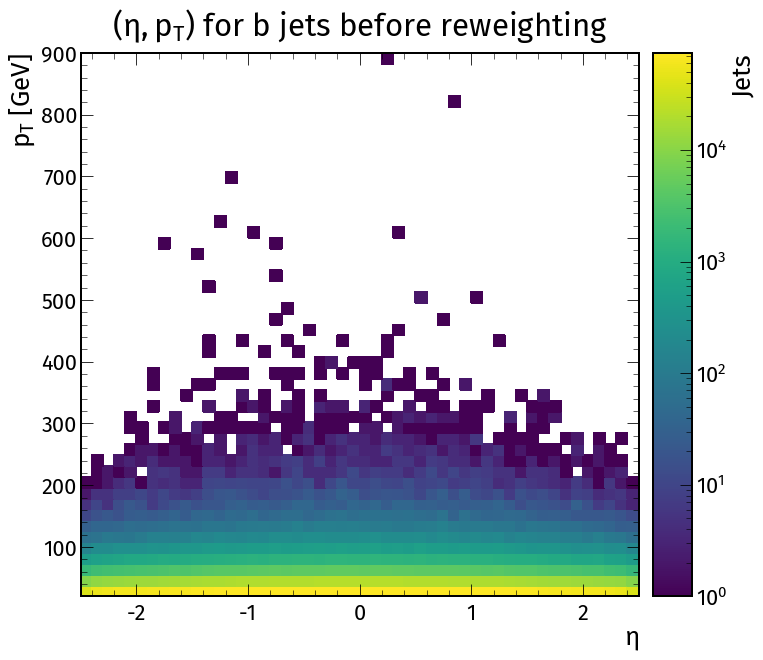

In [207]:
filename = 'b_histo'
ax = hep.hist2dplot(b_histo, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for b jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

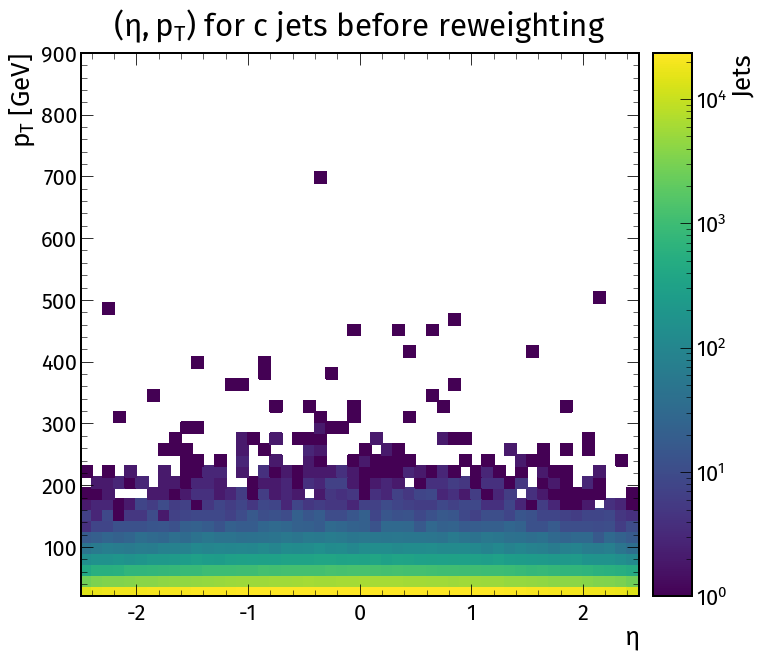

In [208]:
filename = 'c_histo'
ax = hep.hist2dplot(c_histo, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for c jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

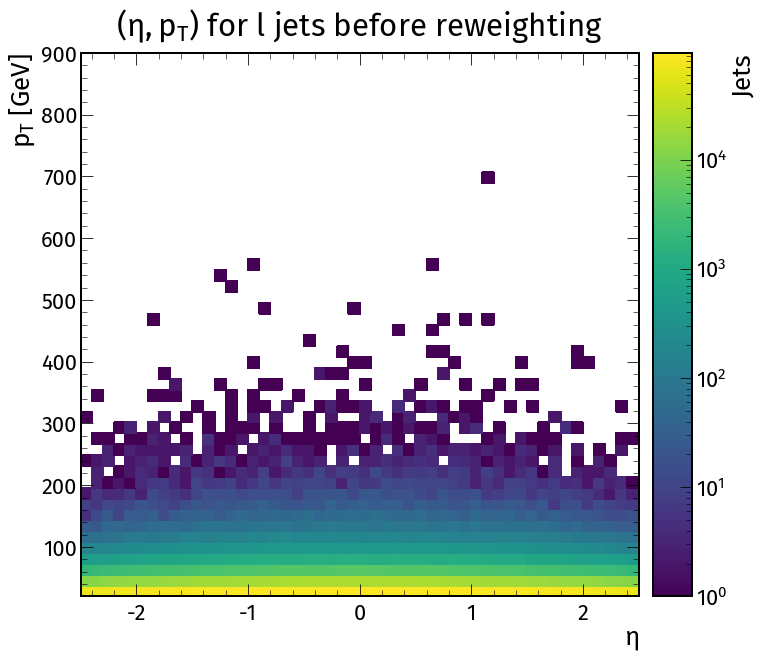

In [209]:
filename = 'l_histo'
ax = hep.hist2dplot(l_histo, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for l jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

### Calculate weights with different normalizations

Derive normed histograms, average histogram, and factors to go from the original to the target.

In [41]:
factor_b = total/b_jets
factor_c = total/c_jets
factor_l = total/l_jets

In [42]:
b_histo_normed = b_histo/sum(b_histo.flatten())
c_histo_normed = c_histo/sum(c_histo.flatten())
l_histo_normed = l_histo/sum(l_histo.flatten())

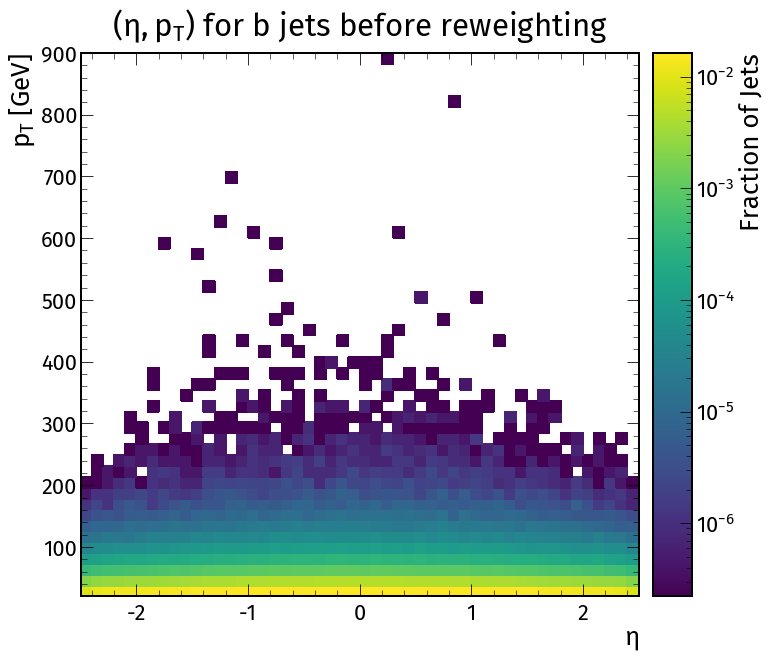

In [92]:
filename = 'b_histo_normed'
ax = hep.hist2dplot(b_histo_normed, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for b jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Fraction of Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

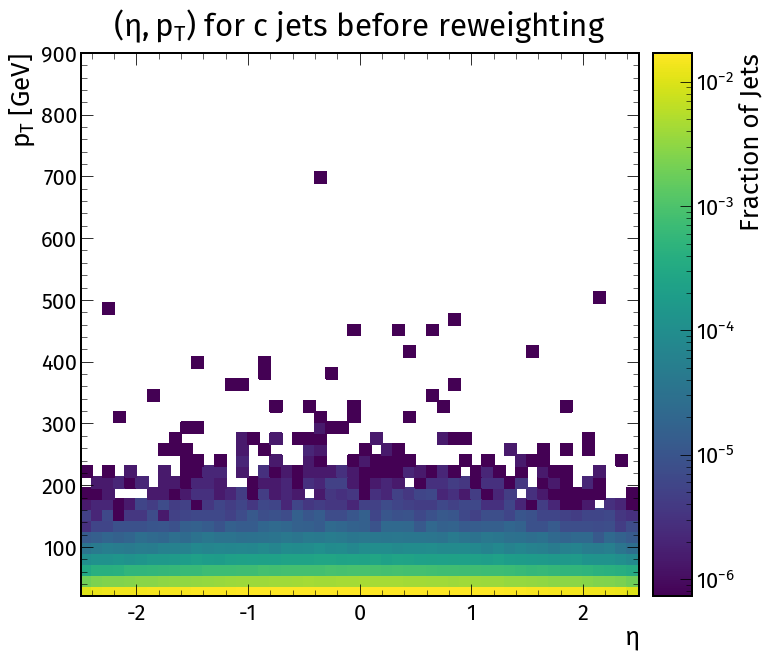

In [93]:
filename = 'c_histo_normed'
ax = hep.hist2dplot(c_histo_normed, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for c jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Fraction of Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

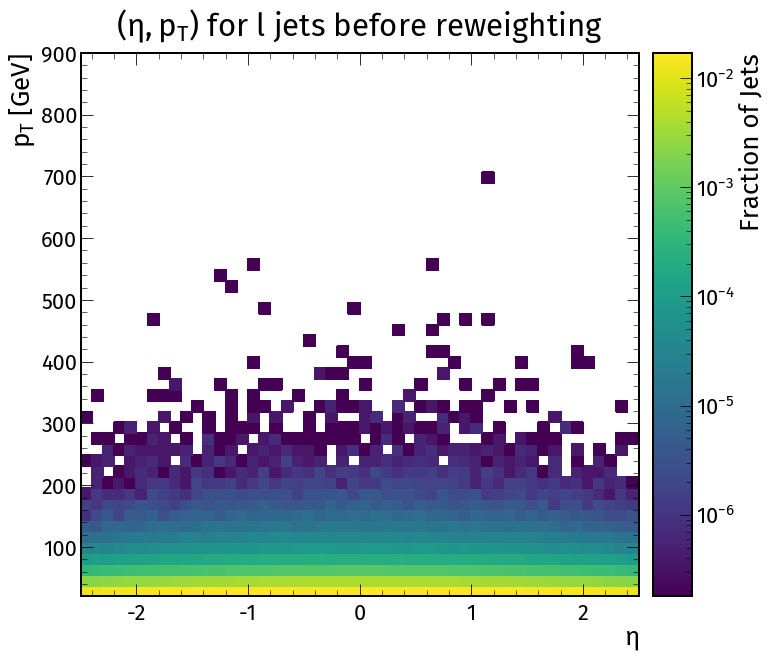

In [94]:
filename = 'l_histo_normed'
ax = hep.hist2dplot(l_histo_normed, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for l jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Fraction of Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

In [59]:
average_normed_histo = (b_histo_normed + c_histo_normed + l_histo_normed)/3

The following weights only account for the different shapes of the pt and eta distributions, but do not apply a class reweighting for the different flavors (with an matching number of samples from each category).

In [60]:
b_weights_pt_eta_average = average_normed_histo/b_histo_normed
c_weights_pt_eta_average = average_normed_histo/c_histo_normed
l_weights_pt_eta_average = average_normed_histo/l_histo_normed

<ipython-input-60-f316e8a35ff6>:1: RuntimeWarning: divide by zero encountered in true_divide
  b_weights_pt_eta_average = average_normed_histo/b_histo_normed
<ipython-input-60-f316e8a35ff6>:1: RuntimeWarning: invalid value encountered in true_divide
  b_weights_pt_eta_average = average_normed_histo/b_histo_normed
<ipython-input-60-f316e8a35ff6>:2: RuntimeWarning: divide by zero encountered in true_divide
  c_weights_pt_eta_average = average_normed_histo/c_histo_normed
<ipython-input-60-f316e8a35ff6>:2: RuntimeWarning: invalid value encountered in true_divide
  c_weights_pt_eta_average = average_normed_histo/c_histo_normed
<ipython-input-60-f316e8a35ff6>:3: RuntimeWarning: divide by zero encountered in true_divide
  l_weights_pt_eta_average = average_normed_histo/l_histo_normed
<ipython-input-60-f316e8a35ff6>:3: RuntimeWarning: invalid value encountered in true_divide
  l_weights_pt_eta_average = average_normed_histo/l_histo_normed


In [76]:
b_weights_pt_eta_average

array([[1.20306087, 0.99557254, 0.89265875, ...,        nan,        nan,
               nan],
       [1.03155484, 0.92445644, 0.87172029, ...,        nan,        nan,
               nan],
       [1.0312934 , 0.9209305 , 0.85565372, ...,        nan,        nan,
               nan],
       ...,
       [1.02577417, 0.89911965, 0.87181452, ...,        nan,        nan,
               nan],
       [1.04051075, 0.90579247, 0.88831734, ...,        nan,        nan,
               nan],
       [1.20385096, 0.9687892 , 0.93537015, ...,        nan,        nan,
               nan]])

In [77]:
c_weights_pt_eta_average

array([[1.03700855, 1.06467809, 1.15570709, ...,        nan,        nan,
               nan],
       [1.00464207, 1.01423795, 1.04794556, ...,        nan,        nan,
               nan],
       [0.99204033, 1.02224728, 1.09545322, ...,        nan,        nan,
               nan],
       ...,
       [0.99607087, 1.04828415, 1.08838017, ...,        nan,        nan,
               nan],
       [0.99863657, 1.05414957, 1.07427286, ...,        nan,        nan,
               nan],
       [1.03112814, 1.10245226, 1.0844395 , ...,        nan,        nan,
               nan]])

In [78]:
l_weights_pt_eta_average

array([[0.83023747, 0.94669912, 0.98572675, ...,        nan,        nan,
               nan],
       [0.96598738, 1.07259155, 1.1128484 , ...,        nan,        nan,
               nan],
       [0.97816702, 1.0684847 , 1.08880424, ...,        nan,        nan,
               nan],
       ...,
       [0.97925744, 1.07082301, 1.07046848, ...,        nan,        nan,
               nan],
       [0.96379203, 1.0555623 , 1.05998006, ...,        nan,        nan,
               nan],
       [0.83366623, 0.94276036, 0.99130706, ...,        nan,        nan,
               nan]])

Because these weights only account for the kinematic variables, the weights are close to 1. However, one also needs to correct for the class imbalance, where the weights will naturally drift away from each other.

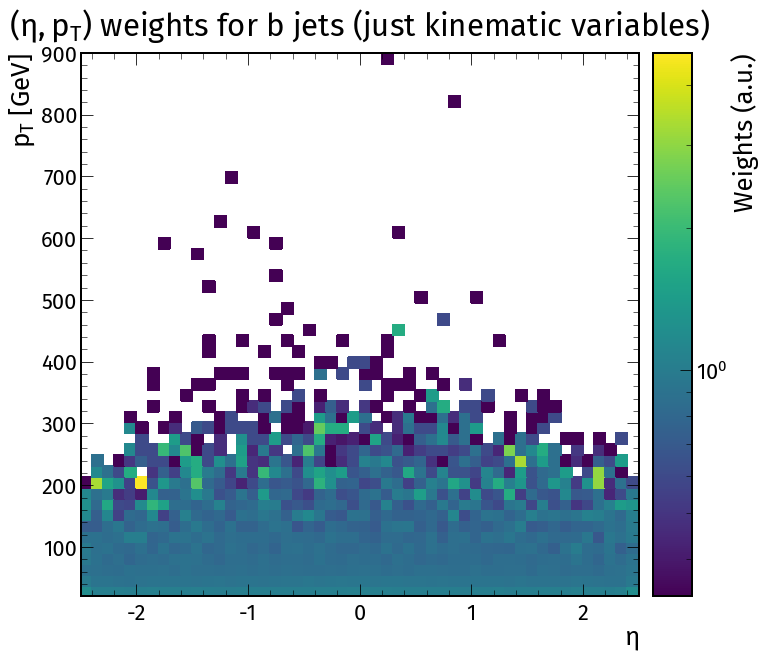

In [104]:
filename = 'b_weights_pt_eta_average'
ax = hep.hist2dplot(b_weights_pt_eta_average, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for b jets (just kinematic variables)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

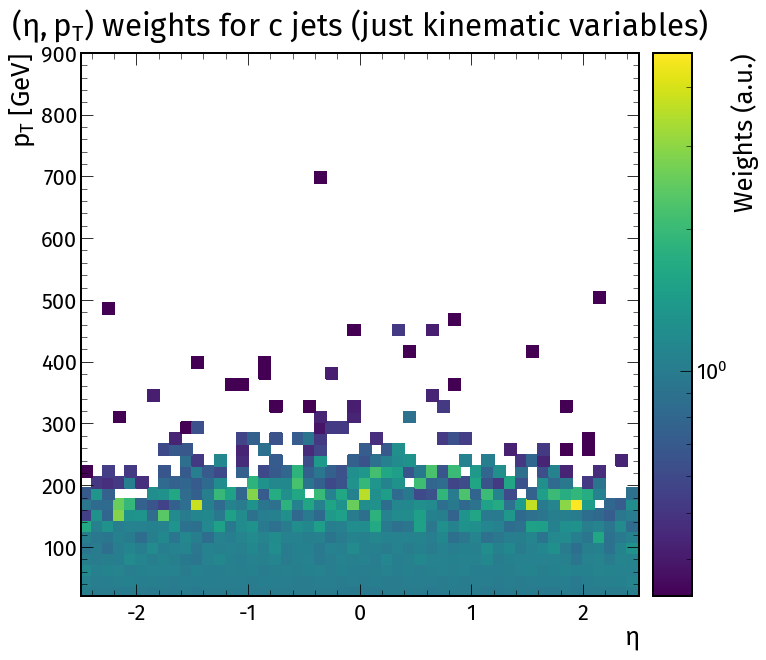

In [105]:
filename = 'c_weights_pt_eta_average'
ax = hep.hist2dplot(c_weights_pt_eta_average, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for c jets (just kinematic variables)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

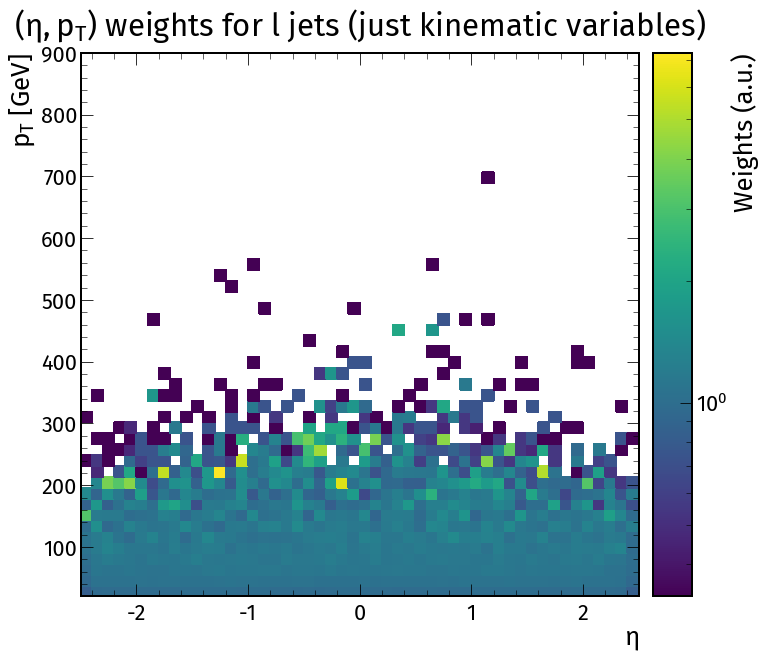

In [106]:
filename = 'l_weights_pt_eta_average'
ax = hep.hist2dplot(l_weights_pt_eta_average, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for l jets (just kinematic variables)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

The next weights are using the previous weights and multiply a correction factor based on the number of jets in each target class.

In [45]:
b_weights_pt_eta_flav = b_weights_pt_eta_average * factor_b
c_weights_pt_eta_flav = c_weights_pt_eta_average * factor_c
l_weights_pt_eta_flav = l_weights_pt_eta_average * factor_l

In [46]:
b_weights_pt_eta_flav

array([[3.06142599, 2.53343096, 2.27154649, ...,        nan,        nan,
               nan],
       [2.62499504, 2.35246199, 2.21826444, ...,        nan,        nan,
               nan],
       [2.62432976, 2.34348954, 2.17737988, ...,        nan,        nan,
               nan],
       ...,
       [2.61028498, 2.28798752, 2.21850424, ...,        nan,        nan,
               nan],
       [2.64778512, 2.30496785, 2.26049892, ...,        nan,        nan,
               nan],
       [3.06343654, 2.46527546, 2.3802341 , ...,        nan,        nan,
               nan]])

Note: these values are _not_ close to 1.

In [74]:
c_weights_pt_eta_flav

array([[8.64928641, 8.88006729, 9.63930484, ...,        nan,        nan,
               nan],
       [8.37933013, 8.45936566, 8.74050771, ...,        nan,        nan,
               nan],
       [8.27422383, 8.52616834, 9.13675069, ...,        nan,        nan,
               nan],
       ...,
       [8.30784104, 8.74333176, 9.07775716, ...,        nan,        nan,
               nan],
       [8.32924056, 8.79225294, 8.96009356, ...,        nan,        nan,
               nan],
       [8.60024018, 9.19512695, 9.04488957, ...,        nan,        nan,
               nan]])

In [75]:
l_weights_pt_eta_flav

array([[1.7043423 , 1.94341909, 2.02353645, ...,        nan,        nan,
               nan],
       [1.98301473, 2.20185574, 2.2844965 , ...,        nan,        nan,
               nan],
       [2.00801755, 2.19342505, 2.23513775, ...,        nan,        nan,
               nan],
       ...,
       [2.01025601, 2.19822522, 2.19749741, ...,        nan,        nan,
               nan],
       [1.97850805, 2.16689745, 2.17596641, ...,        nan,        nan,
               nan],
       [1.71138097, 1.93533345, 2.03499191, ...,        nan,        nan,
               nan]])

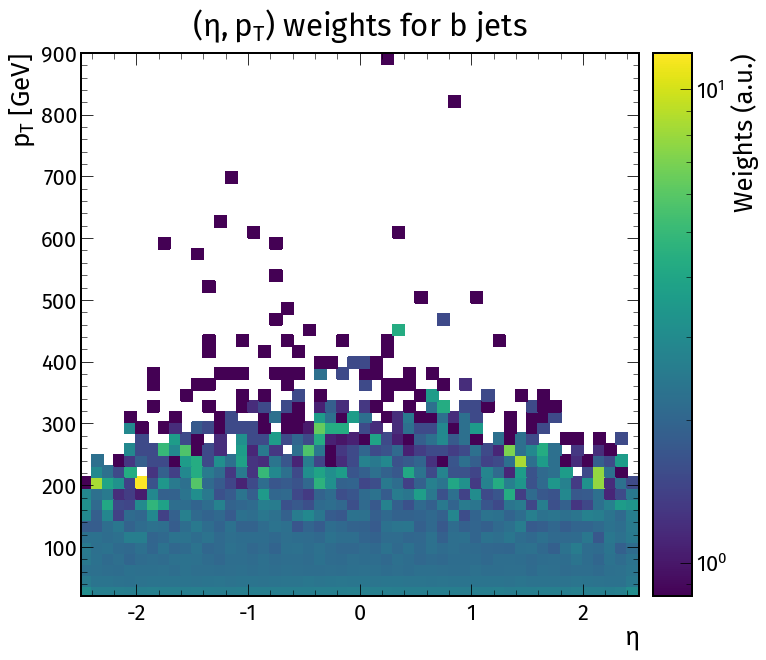

In [101]:
filename = 'b_weights_pt_eta_flav'
ax = hep.hist2dplot(b_weights_pt_eta_flav, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for b jets',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

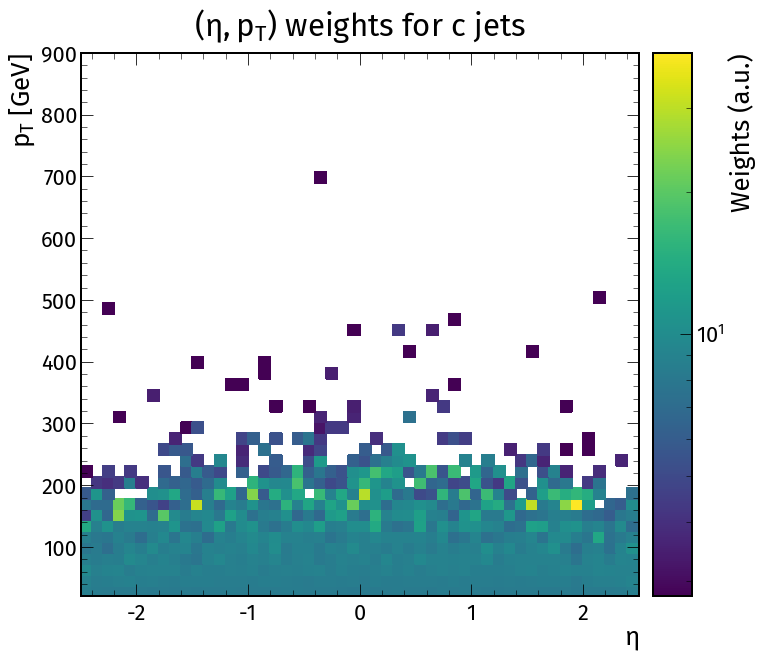

In [102]:
filename = 'c_weights_pt_eta_flav'
ax = hep.hist2dplot(c_weights_pt_eta_flav, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for c jets',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

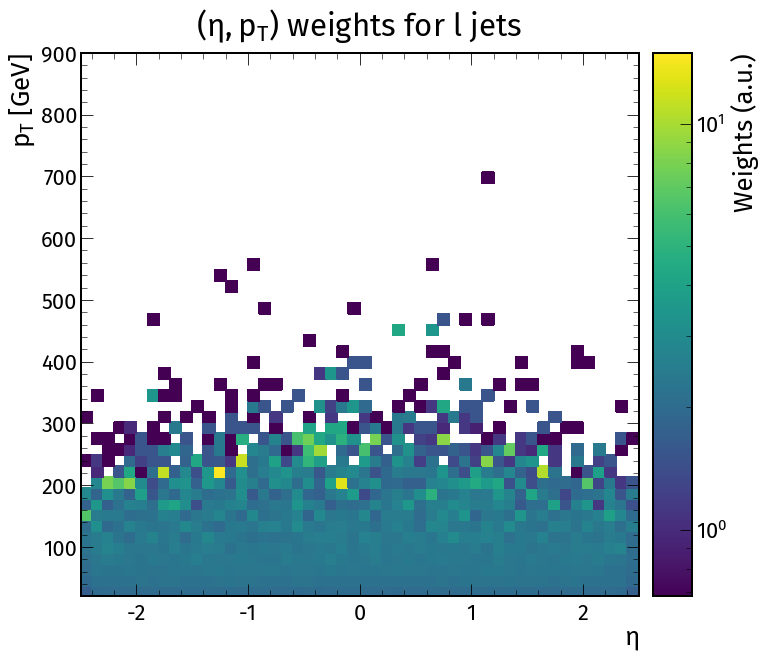

In [103]:
filename = 'l_weights_pt_eta_flav'
ax = hep.hist2dplot(l_weights_pt_eta_flav, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for l jets',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

Normed reweighting divides the originally (previously) obtained sample weights by the sum of the flavor-factors.  
The qualitative behaviour will not change, only the scale of the sample weights.

In [54]:
norm_factor = (factor_b+factor_c+factor_l)

In [57]:
b_weights_pt_eta_flav_normed = b_weights_pt_eta_flav / norm_factor
c_weights_pt_eta_flav_normed = c_weights_pt_eta_flav / norm_factor
l_weights_pt_eta_flav_normed = l_weights_pt_eta_flav / norm_factor

In [58]:
b_weights_pt_eta_flav_normed

array([[0.23662013, 0.19581096, 0.17556969, ...,        nan,        nan,
               nan],
       [0.20288802, 0.18182372, 0.17145148, ...,        nan,        nan,
               nan],
       [0.2028366 , 0.18113023, 0.16829148, ...,        nan,        nan,
               nan],
       ...,
       [0.20175107, 0.17684043, 0.17147001, ...,        nan,        nan,
               nan],
       [0.20464948, 0.17815286, 0.17471582, ...,        nan,        nan,
               nan],
       [0.23677552, 0.19054316, 0.18397025, ...,        nan,        nan,
               nan]])

Note: these values are _not_ close to 1.

In [72]:
c_weights_pt_eta_flav_normed

array([[0.66851044, 0.68634769, 0.74502978, ...,        nan,        nan,
               nan],
       [0.6476453 , 0.65383131, 0.67556101, ...,        nan,        nan,
               nan],
       [0.63952155, 0.65899455, 0.70618696, ...,        nan,        nan,
               nan],
       ...,
       [0.64211985, 0.67577929, 0.7016273 , ...,        nan,        nan,
               nan],
       [0.64377384, 0.67956045, 0.69253298, ...,        nan,        nan,
               nan],
       [0.66471962, 0.71069891, 0.69908694, ...,        nan,        nan,
               nan]])

In [73]:
l_weights_pt_eta_flav_normed

array([[0.13173001, 0.15020846, 0.15640079, ...,        nan,        nan,
               nan],
       [0.15326884, 0.17018324, 0.17657061, ...,        nan,        nan,
               nan],
       [0.15520132, 0.16953162, 0.17275563, ...,        nan,        nan,
               nan],
       ...,
       [0.15537434, 0.16990263, 0.16984638, ...,        nan,        nan,
               nan],
       [0.15292051, 0.16748128, 0.16818223, ...,        nan,        nan,
               nan],
       [0.13227404, 0.14958351, 0.15728619, ...,        nan,        nan,
               nan]])

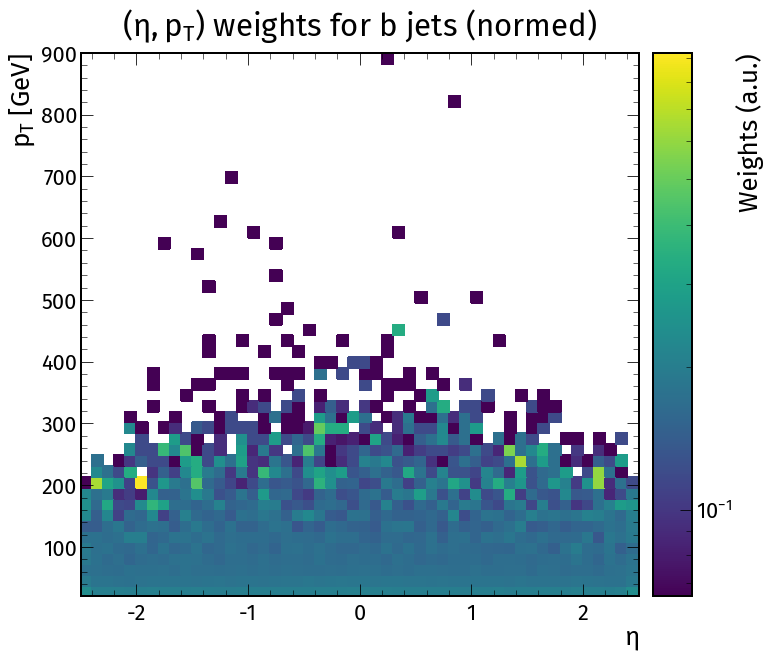

In [98]:
filename = 'b_weights_pt_eta_flav_normed'
ax = hep.hist2dplot(b_weights_pt_eta_flav_normed, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for b jets (normed)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

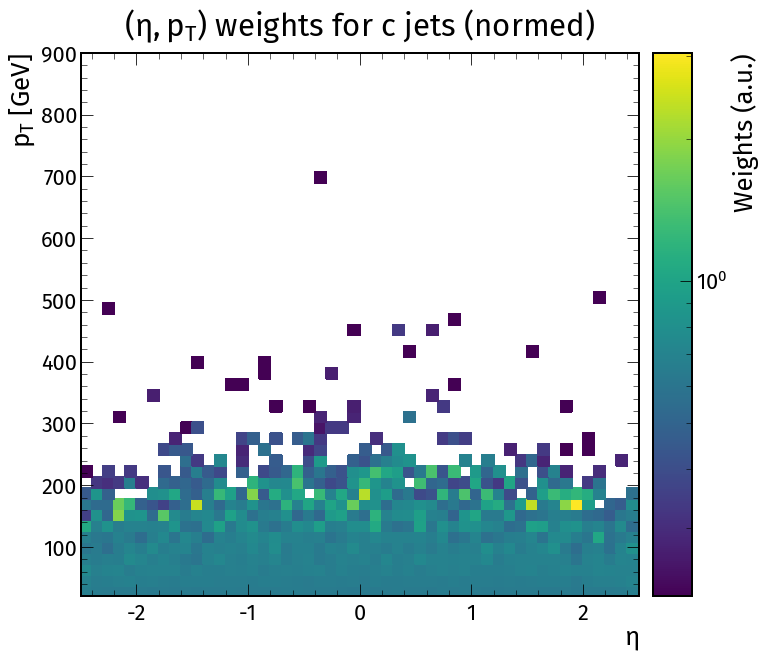

In [99]:
filename = 'c_weights_pt_eta_flav_normed'
ax = hep.hist2dplot(c_weights_pt_eta_flav_normed, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for c jets (normed)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

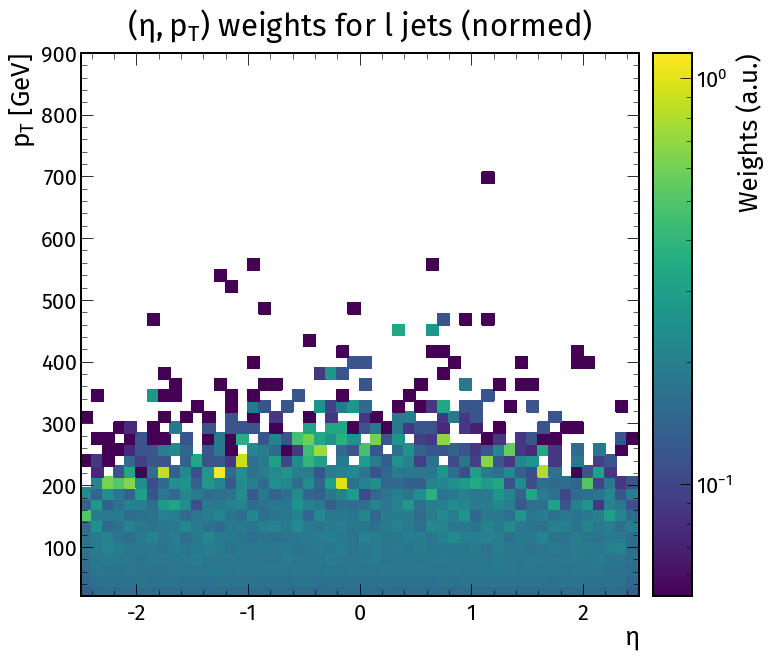

In [100]:
filename = 'l_weights_pt_eta_flav_normed'
ax = hep.hist2dplot(l_weights_pt_eta_flav_normed, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for l jets (normed)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

Balanced reweighting divides the originally obtained sample weights by the number of classes.  
The qualitative behaviour will not change, only the scale of the sample weights.

In [52]:
b_weights_pt_eta_flav_balanced = b_weights_pt_eta_flav / 3
c_weights_pt_eta_flav_balanced = c_weights_pt_eta_flav / 3
l_weights_pt_eta_flav_balanced = l_weights_pt_eta_flav / 3

In [53]:
b_weights_pt_eta_flav_balanced

array([[1.02047533, 0.84447699, 0.75718216, ...,        nan,        nan,
               nan],
       [0.87499835, 0.784154  , 0.73942148, ...,        nan,        nan,
               nan],
       [0.87477659, 0.78116318, 0.72579329, ...,        nan,        nan,
               nan],
       ...,
       [0.87009499, 0.76266251, 0.73950141, ...,        nan,        nan,
               nan],
       [0.88259504, 0.76832262, 0.75349964, ...,        nan,        nan,
               nan],
       [1.02114551, 0.82175849, 0.79341137, ...,        nan,        nan,
               nan]])

In [70]:
c_weights_pt_eta_flav_balanced

array([[2.88309547, 2.96002243, 3.21310161, ...,        nan,        nan,
               nan],
       [2.79311004, 2.81978855, 2.91350257, ...,        nan,        nan,
               nan],
       [2.75807461, 2.84205611, 3.04558356, ...,        nan,        nan,
               nan],
       ...,
       [2.76928035, 2.91444392, 3.02591905, ...,        nan,        nan,
               nan],
       [2.77641352, 2.93075098, 2.98669785, ...,        nan,        nan,
               nan],
       [2.86674673, 3.06504232, 3.01496319, ...,        nan,        nan,
               nan]])

In [71]:
l_weights_pt_eta_flav_balanced

array([[0.5681141 , 0.64780636, 0.67451215, ...,        nan,        nan,
               nan],
       [0.66100491, 0.73395191, 0.76149883, ...,        nan,        nan,
               nan],
       [0.66933918, 0.73114168, 0.74504592, ...,        nan,        nan,
               nan],
       ...,
       [0.67008534, 0.73274174, 0.73249914, ...,        nan,        nan,
               nan],
       [0.65950268, 0.72229915, 0.72532214, ...,        nan,        nan,
               nan],
       [0.57046032, 0.64511115, 0.67833064, ...,        nan,        nan,
               nan]])

Note: these values are close to 1.

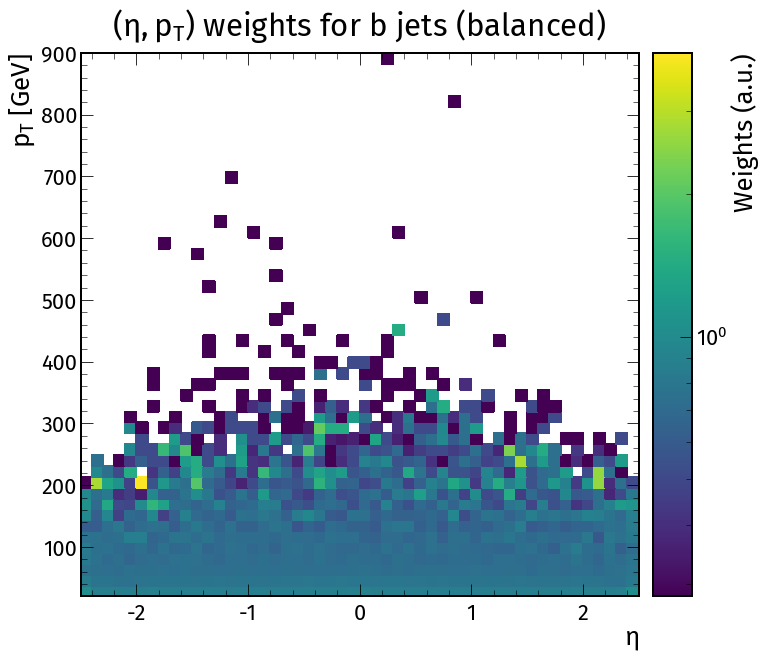

In [97]:
filename = 'b_weights_pt_eta_flav_balanced'
ax = hep.hist2dplot(b_weights_pt_eta_flav_balanced, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for b jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

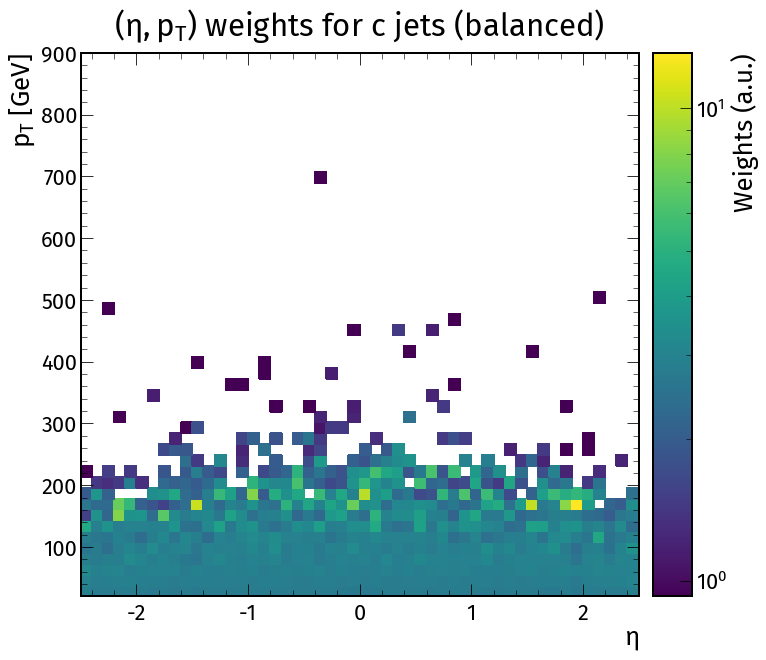

In [96]:
filename = 'c_weights_pt_eta_flav_balanced'
ax = hep.hist2dplot(c_weights_pt_eta_flav_balanced, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for c jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

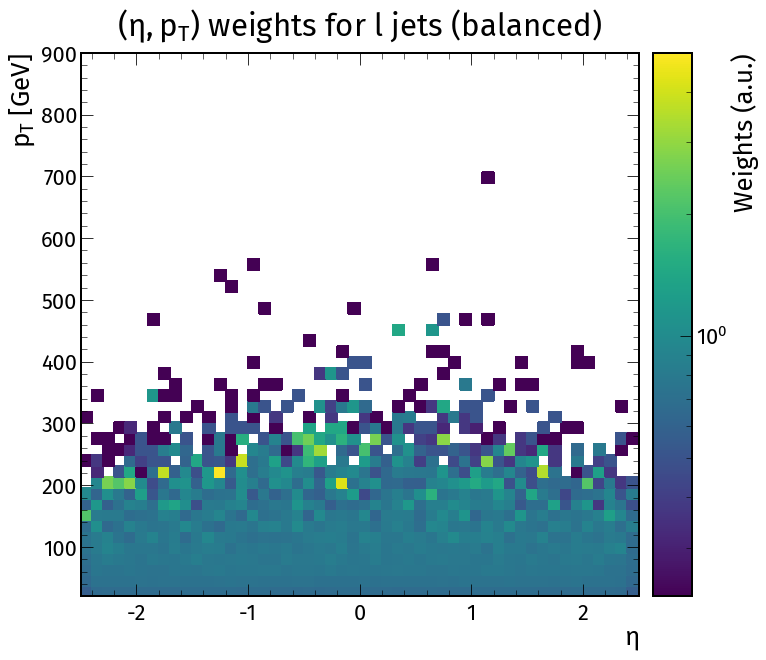

In [95]:
filename = 'l_weights_pt_eta_flav_balanced'
ax = hep.hist2dplot(l_weights_pt_eta_flav_balanced, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for l jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

Another method would use the original histograms directly to get the average as the target:

In [61]:
average_absolute_histo = (b_histo + c_histo + l_histo)/3

In [66]:
b_weights_pt_eta_flav_absolute = average_absolute_histo / b_histo
c_weights_pt_eta_flav_absolute = average_absolute_histo / c_histo
l_weights_pt_eta_flav_absolute = average_absolute_histo / l_histo

<ipython-input-66-c1c66bfafd48>:1: RuntimeWarning: divide by zero encountered in true_divide
  b_weights_pt_eta_flav_absolute = average_absolute_histo / b_histo
<ipython-input-66-c1c66bfafd48>:1: RuntimeWarning: invalid value encountered in true_divide
  b_weights_pt_eta_flav_absolute = average_absolute_histo / b_histo
<ipython-input-66-c1c66bfafd48>:2: RuntimeWarning: divide by zero encountered in true_divide
  c_weights_pt_eta_flav_absolute = average_absolute_histo / c_histo
<ipython-input-66-c1c66bfafd48>:2: RuntimeWarning: invalid value encountered in true_divide
  c_weights_pt_eta_flav_absolute = average_absolute_histo / c_histo
<ipython-input-66-c1c66bfafd48>:3: RuntimeWarning: divide by zero encountered in true_divide
  l_weights_pt_eta_flav_absolute = average_absolute_histo / l_histo
<ipython-input-66-c1c66bfafd48>:3: RuntimeWarning: invalid value encountered in true_divide
  l_weights_pt_eta_flav_absolute = average_absolute_histo / l_histo


In [67]:
b_weights_pt_eta_flav_absolute

array([[1.05006732, 0.86296296, 0.78607242, ...,        nan,        nan,
               nan],
       [0.87900328, 0.78216311, 0.74159976, ...,        nan,        nan,
               nan],
       [0.87469833, 0.78109135, 0.73748975, ...,        nan,        nan,
               nan],
       ...,
       [0.87089307, 0.7675059 , 0.75131615, ...,        nan,        nan,
               nan],
       [0.88538798, 0.77529232, 0.76371115, ...,        nan,        nan,
               nan],
       [1.04874712, 0.84731046, 0.81093692, ...,        nan,        nan,
               nan]])

Note: these values are close to 1.

In [68]:
c_weights_pt_eta_flav_absolute

array([[2.96670016, 3.02481863, 3.3356974 , ...,        nan,        nan,
               nan],
       [2.80589431, 2.8126294 , 2.92208553, ...,        nan,        nan,
               nan],
       [2.7578279 , 2.8417948 , 3.09466437, ...,        nan,        nan,
               nan],
       ...,
       [2.7718204 , 2.9329525 , 3.07426304, ...,        nan,        nan,
               nan],
       [2.7851994 , 2.95733678, 3.02717391, ...,        nan,        nan,
               nan],
       [2.94423501, 3.16034755, 3.08156028, ...,        nan,        nan,
               nan]])

In [69]:
l_weights_pt_eta_flav_absolute

array([[0.58458841, 0.66198713, 0.70024814, ...,        nan,        nan,
               nan],
       [0.66403038, 0.73208849, 0.76374215, ...,        nan,        nan,
               nan],
       [0.66927931, 0.73107446, 0.75705263, ...,        nan,        nan,
               nan],
       ...,
       [0.67069996, 0.73739512, 0.744202  , ...,        nan,        nan,
               nan],
       [0.66158966, 0.72885136, 0.73515178, ...,        nan,        nan,
               nan],
       [0.58587989, 0.66517041, 0.69331419, ...,        nan,        nan,
               nan]])

Note 2: with the second method, the weights are larger than the ones obtained from the first method to average the distributions. Maybe the total numbers are only conserved in one of the two strategies, but both account for the kinematic reweighting as well as the class imbalance.

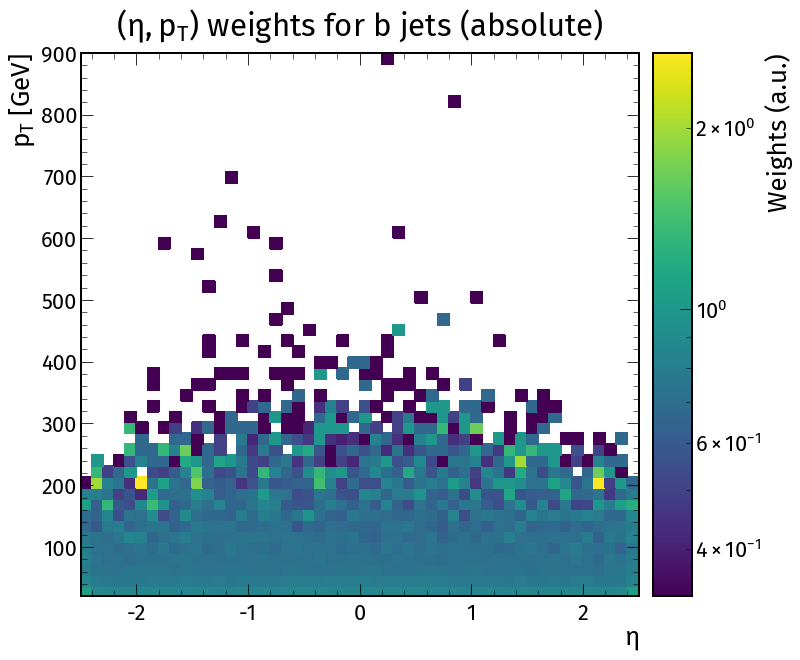

In [87]:
filename = 'b_weights_pt_eta_flav_absolute'
ax = hep.hist2dplot(b_weights_pt_eta_flav_absolute, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for b jets (absolute)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

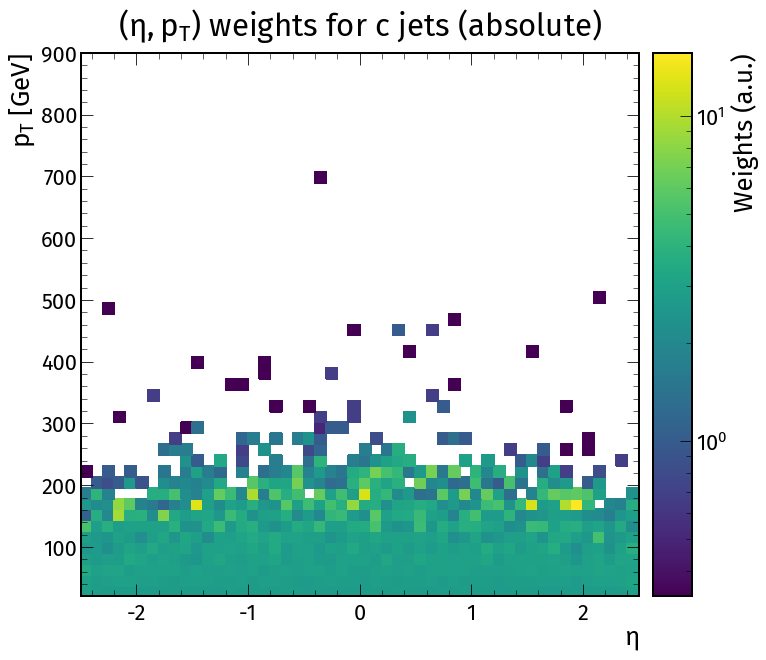

In [88]:
filename = 'c_weights_pt_eta_flav_absolute'
ax = hep.hist2dplot(c_weights_pt_eta_flav_absolute, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for c jets (absolute)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

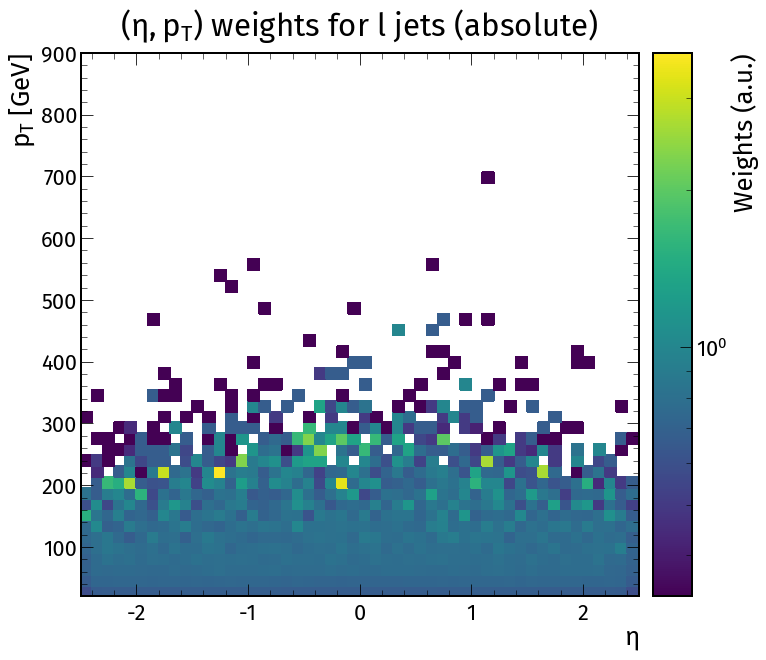

In [90]:
filename = 'l_weights_pt_eta_flav_absolute'
ax = hep.hist2dplot(l_weights_pt_eta_flav_absolute, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for l jets (absolute)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

## Check resulting distributions, if weights would be applied during resampling

No need to check all of them, but at least the two strategies with similar values in the end.

Check the total number of jets, if one would resample based on the weights:

In [112]:
b_reweighted_pt_eta_flav_balanced = b_weights_pt_eta_flav_balanced * b_histo
c_reweighted_pt_eta_flav_balanced = c_weights_pt_eta_flav_balanced * c_histo
l_reweighted_pt_eta_flav_balanced = l_weights_pt_eta_flav_balanced * l_histo

<ipython-input-112-ef72638a8c35>:1: RuntimeWarning: invalid value encountered in multiply
  b_reweighted_pt_eta_flav_balanced = b_weights_pt_eta_flav_balanced * b_histo
<ipython-input-112-ef72638a8c35>:2: RuntimeWarning: invalid value encountered in multiply
  c_reweighted_pt_eta_flav_balanced = c_weights_pt_eta_flav_balanced * c_histo
<ipython-input-112-ef72638a8c35>:3: RuntimeWarning: invalid value encountered in multiply
  l_reweighted_pt_eta_flav_balanced = l_weights_pt_eta_flav_balanced * l_histo


In [123]:
reweighted_balanced_total = sum(np.nan_to_num(b_reweighted_pt_eta_flav_balanced.flatten() + c_reweighted_pt_eta_flav_balanced.flatten() + l_reweighted_pt_eta_flav_balanced.flatten()))
reweighted_balanced_total

11490984.796957726

In [116]:
b_reweighted_pt_eta_flav_absolute = b_weights_pt_eta_flav_absolute * b_histo
c_reweighted_pt_eta_flav_absolute = c_weights_pt_eta_flav_absolute * c_histo
l_reweighted_pt_eta_flav_absolute = l_weights_pt_eta_flav_absolute * l_histo

<ipython-input-116-9c726aa51daf>:1: RuntimeWarning: invalid value encountered in multiply
  b_reweighted_pt_eta_flav_absolute = b_weights_pt_eta_flav_absolute * b_histo
<ipython-input-116-9c726aa51daf>:2: RuntimeWarning: invalid value encountered in multiply
  c_reweighted_pt_eta_flav_absolute = c_weights_pt_eta_flav_absolute * c_histo
<ipython-input-116-9c726aa51daf>:3: RuntimeWarning: invalid value encountered in multiply
  l_reweighted_pt_eta_flav_absolute = l_weights_pt_eta_flav_absolute * l_histo


In [124]:
reweighted_absolute_total = sum(np.nan_to_num(b_reweighted_pt_eta_flav_absolute.flatten() + c_reweighted_pt_eta_flav_absolute.flatten() + l_reweighted_pt_eta_flav_absolute.flatten()))
reweighted_absolute_total

11490814.0

Note: both numbers are smaller than the total number of jets in the dataset (11491971), but the first option seems to be closer to the desired value. The two versions suffer differently from empty bins it seems.

Plot the reweighted distributions, if one would resample based on the weights:

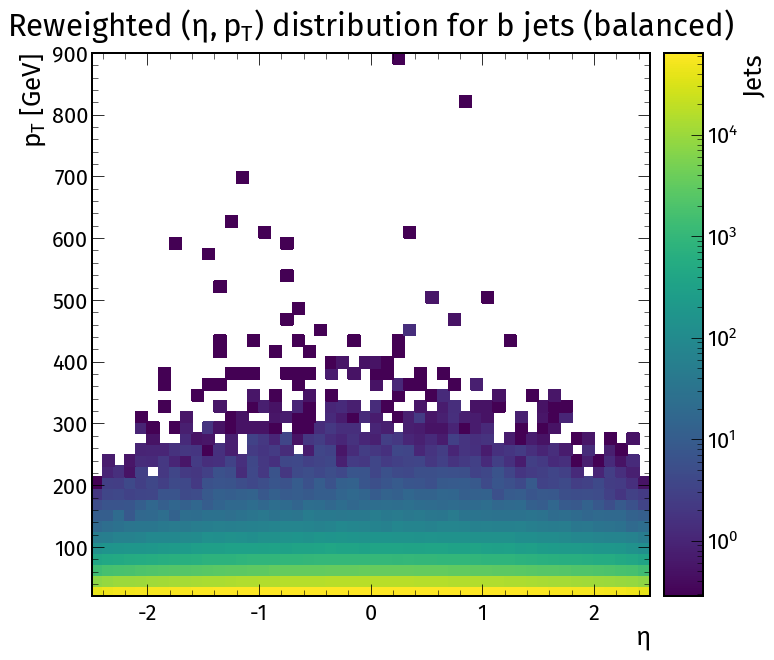

In [338]:
filename = 'b_reweighted_pt_eta_flav_balanced'
ax = hep.hist2dplot(b_reweighted_pt_eta_flav_balanced, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'Reweighted $(\eta, p_T)$'+' distribution for b jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

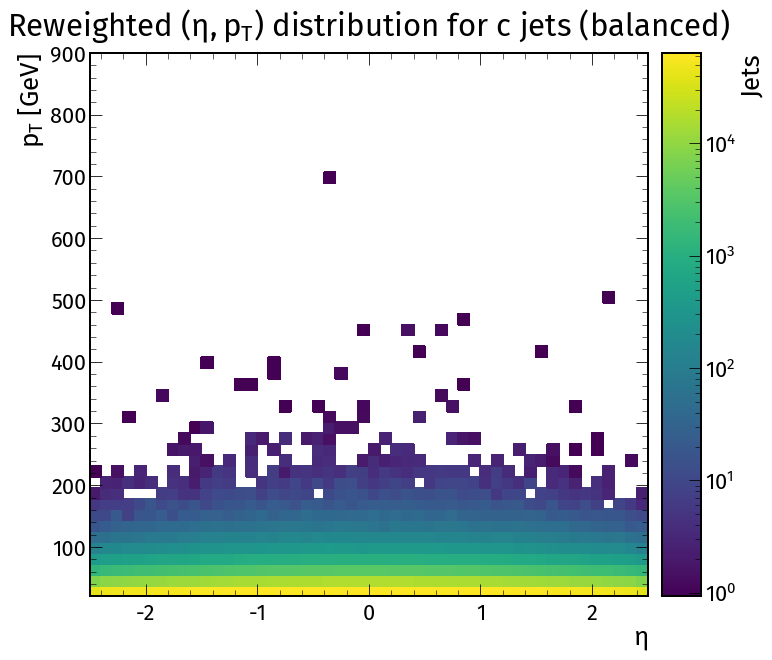

In [339]:
filename = 'c_reweighted_pt_eta_flav_balanced'
ax = hep.hist2dplot(c_reweighted_pt_eta_flav_balanced, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'Reweighted $(\eta, p_T)$'+' distribution for c jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

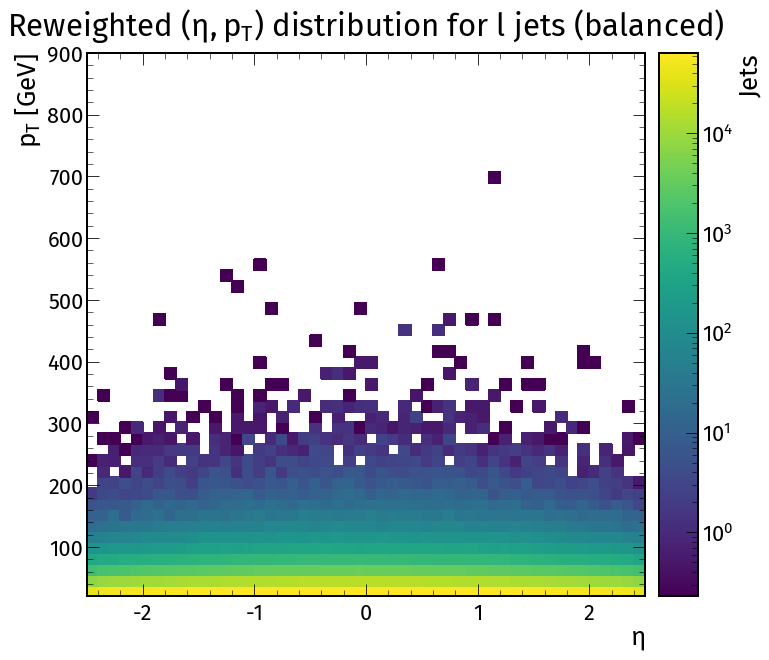

In [340]:
filename = 'l_reweighted_pt_eta_flav_balanced'
ax = hep.hist2dplot(l_reweighted_pt_eta_flav_balanced, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'Reweighted $(\eta, p_T)$'+' distribution for l jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

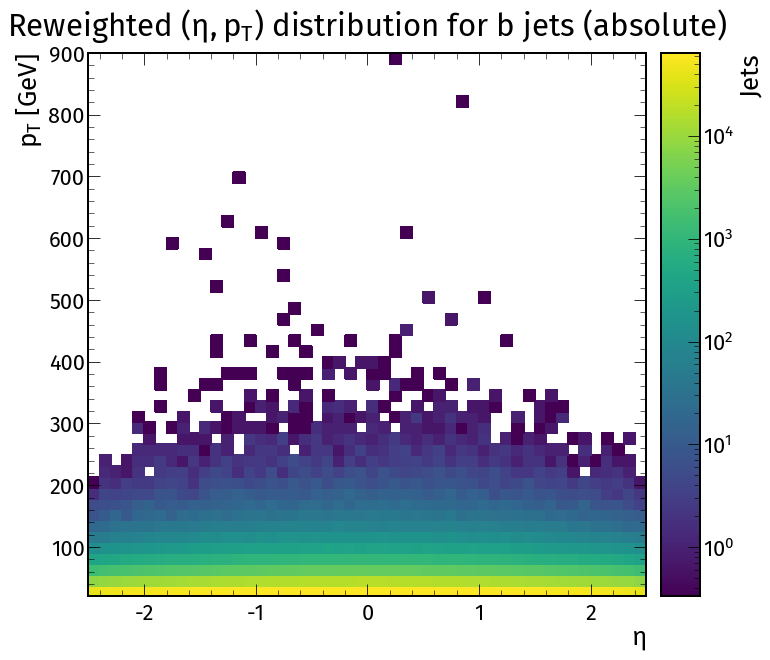

In [121]:
filename = 'b_reweighted_pt_eta_flav_absolute'
ax = hep.hist2dplot(b_reweighted_pt_eta_flav_absolute, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'Reweighted $(\eta, p_T)$'+' distribution for b jets (absolute)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

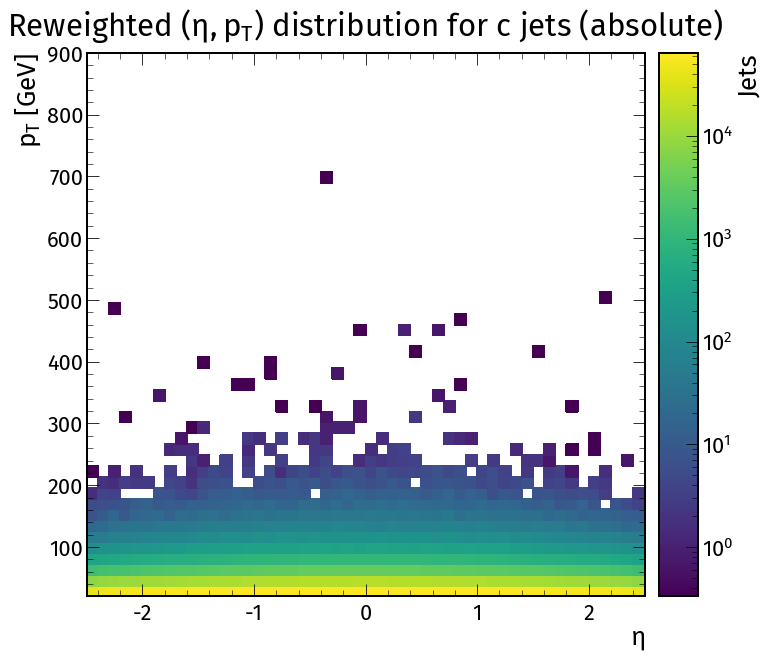

In [120]:
filename = 'c_reweighted_pt_eta_flav_absolute'
ax = hep.hist2dplot(c_reweighted_pt_eta_flav_absolute, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'Reweighted $(\eta, p_T)$'+' distribution for c jets (absolute)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

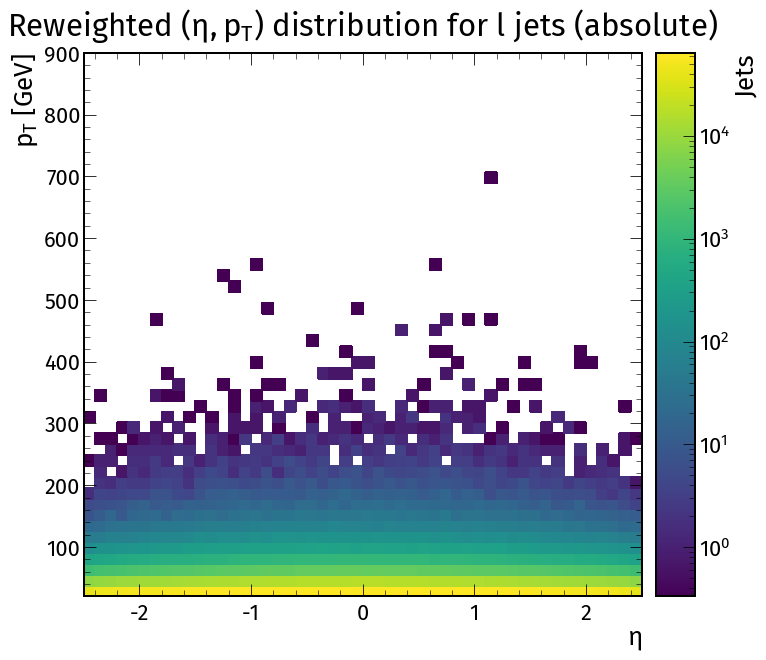

In [119]:
filename = 'l_reweighted_pt_eta_flav_absolute'
ax = hep.hist2dplot(l_reweighted_pt_eta_flav_absolute, eta_edges, pt_edges, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'Reweighted $(\eta, p_T)$'+' distribution for l jets (absolute)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

### Save relevant weights

First option

In [125]:
np.save(weights_path+'b_weights_pt_eta_flav_balanced.npy', b_weights_pt_eta_flav_balanced)
np.save(weights_path+'c_weights_pt_eta_flav_balanced.npy', c_weights_pt_eta_flav_balanced)
np.save(weights_path+'l_weights_pt_eta_flav_balanced.npy', l_weights_pt_eta_flav_balanced)

## Test another binning, with which the dependency on flavour should become more visible
As can be seen from the above plots, mostly the pt-region from 20-300 GeV is filled, so one should maybe increase the binning there and reduce it for the large empty region with high pt. This is specific for this dataset.

In [373]:
custom_pt_range = np.concatenate([np.linspace(20,100,17),np.linspace(110,150,5),np.linspace(200,500,7),np.linspace(600,900,4)])
custom_pt_range

array([ 20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        75.,  80.,  85.,  90.,  95., 100., 110., 120., 130., 140., 150.,
       200., 250., 300., 350., 400., 450., 500., 600., 700., 800., 900.])

In [374]:
len(custom_pt_range)

33

In [375]:
custom_eta_range = np.linspace(-2.5,2.5,51)
custom_eta_range

array([-2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5,
       -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4,
       -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,
        0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,
        1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5])

In [376]:
len(custom_eta_range)

51

In [377]:
b_histo_alt, eta_edges_alt, pt_edges_alt = np.histogram2d(np_array[:,1][np_array[:,-1]==5],np_array[:,0][np_array[:,-1]==5],bins=(custom_eta_range,custom_pt_range),range=((-2.5,2.5),(20,1000)))
c_histo_alt, eta_edges_alt, pt_edges_alt = np.histogram2d(np_array[:,1][np_array[:,-1]==4],np_array[:,0][np_array[:,-1]==4],bins=(custom_eta_range,custom_pt_range),range=((-2.5,2.5),(20,1000)))
l_histo_alt, eta_edges_alt, pt_edges_alt = np.histogram2d(np_array[:,1][np_array[:,-1]==0],np_array[:,0][np_array[:,-1]==0],bins=(custom_eta_range,custom_pt_range),range=((-2.5,2.5),(20,1000)))

In [378]:
np.save(weights_path+'b_histo_alt.npy', b_histo_alt)
np.save(weights_path+'c_histo_alt.npy', c_histo_alt)
np.save(weights_path+'l_histo_alt.npy', l_histo_alt)

In [379]:
np.save(weights_path+'eta_edges_alt.npy', eta_edges_alt)
np.save(weights_path+'pt_edges_alt.npy', pt_edges_alt)

Counts, summed over `jet_pt` and `jet_eta`:

In [380]:
b_jets_alt = sum(b_histo_alt.flatten())
c_jets_alt = sum(c_histo_alt.flatten())
l_jets_alt = sum(l_histo_alt.flatten())

In [381]:
total_alt = b_jets_alt + c_jets_alt + l_jets_alt

In [382]:
b_jets_alt

4516046.0

In [383]:
c_jets_alt

1377833.0

In [384]:
l_jets_alt

5598092.0

In [385]:
total_alt

11491971.0

Note: this cross-check showed that all jets are contained in the chosen binning, because the total number matches the original total.

### Plot original distributions

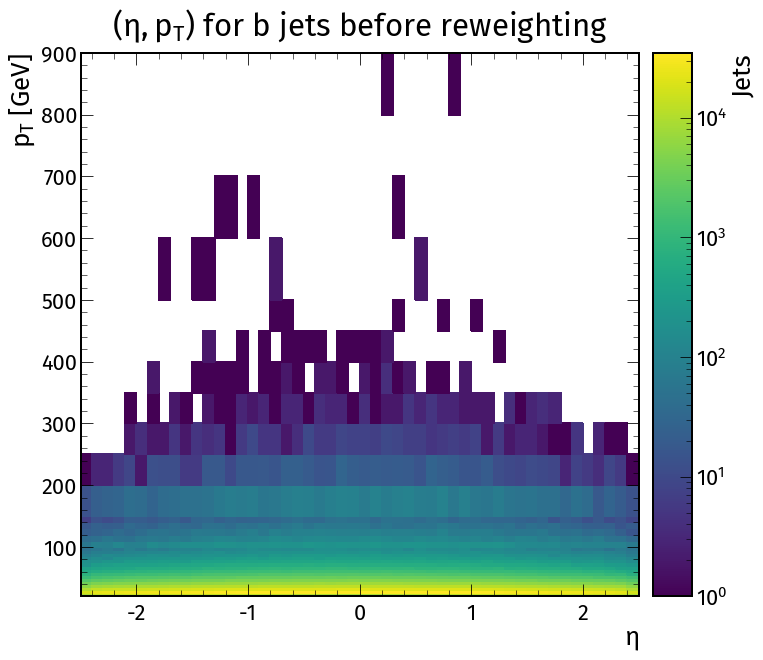

In [386]:
filename = 'b_histo_alt'
ax = hep.hist2dplot(b_histo_alt, eta_edges_alt, pt_edges_alt, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for b jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

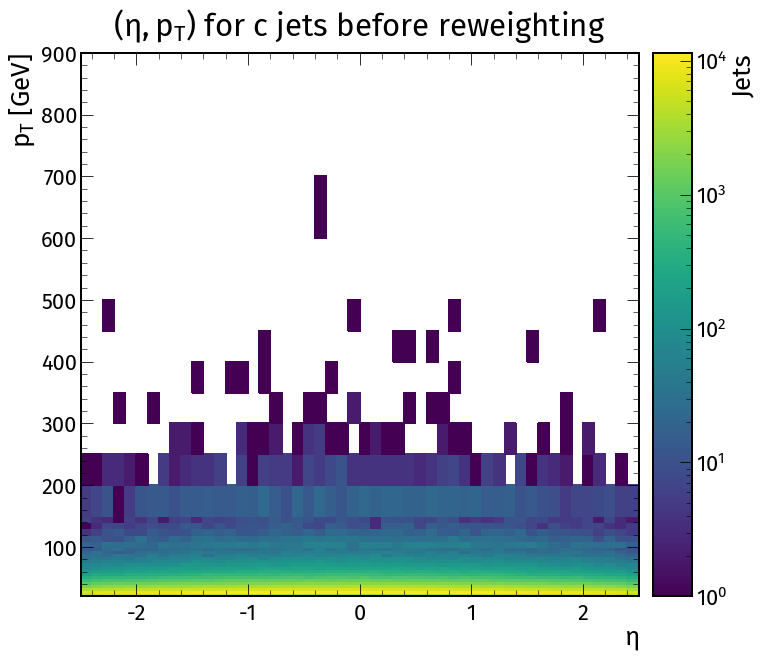

In [387]:
filename = 'c_histo_alt'
ax = hep.hist2dplot(c_histo_alt, eta_edges_alt, pt_edges_alt, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for c jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

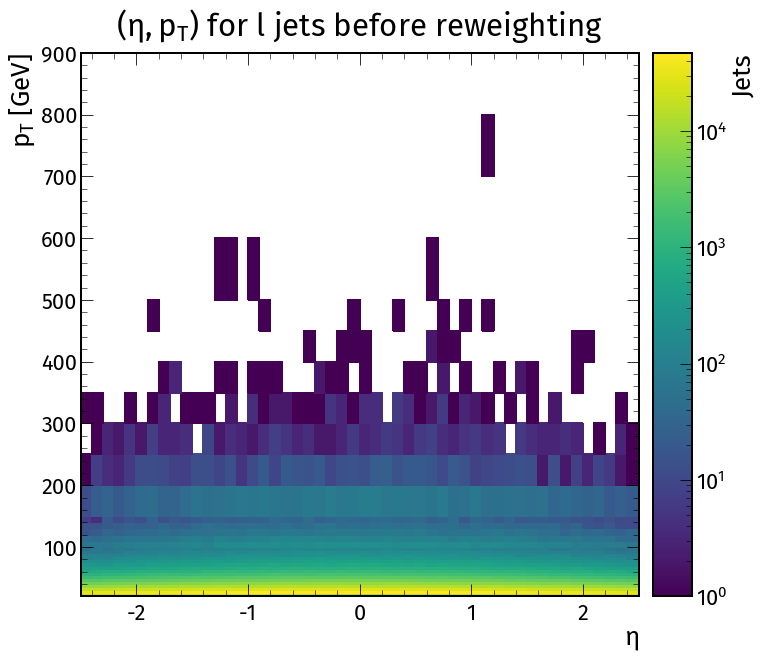

In [388]:
filename = 'l_histo_alt'
ax = hep.hist2dplot(l_histo_alt, eta_edges_alt, pt_edges_alt, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for l jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

An attempt to only look at smallish-pt:

/home/um106329/miniconda3/envs/my-env/lib/python3.8/site-packages/mplhep/plot.py:527: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(X, Y, H, **kwargs)


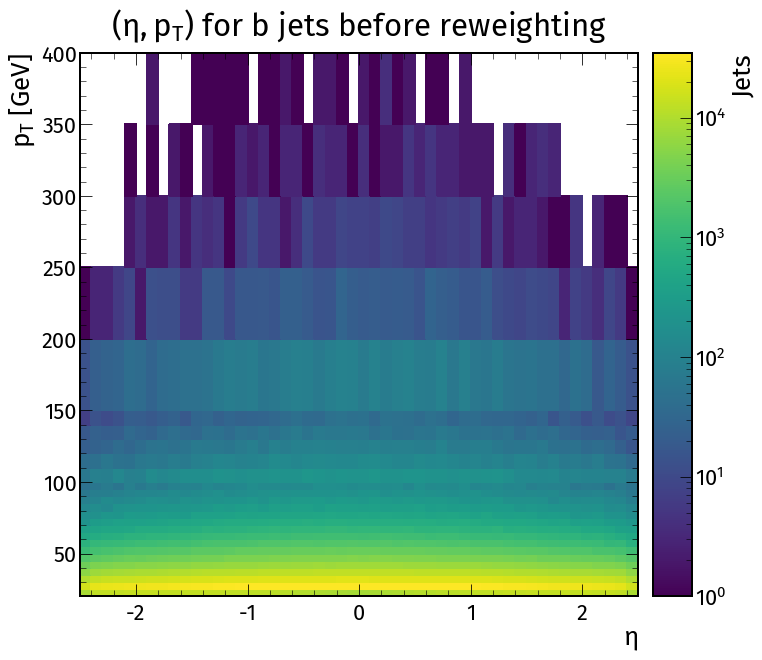

In [389]:
filename = 'b_histo_alt_clip'
ax = hep.hist2dplot(b_histo_alt[:,:27], eta_edges_alt, pt_edges_alt[:27], norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for b jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

/home/um106329/miniconda3/envs/my-env/lib/python3.8/site-packages/mplhep/plot.py:527: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(X, Y, H, **kwargs)


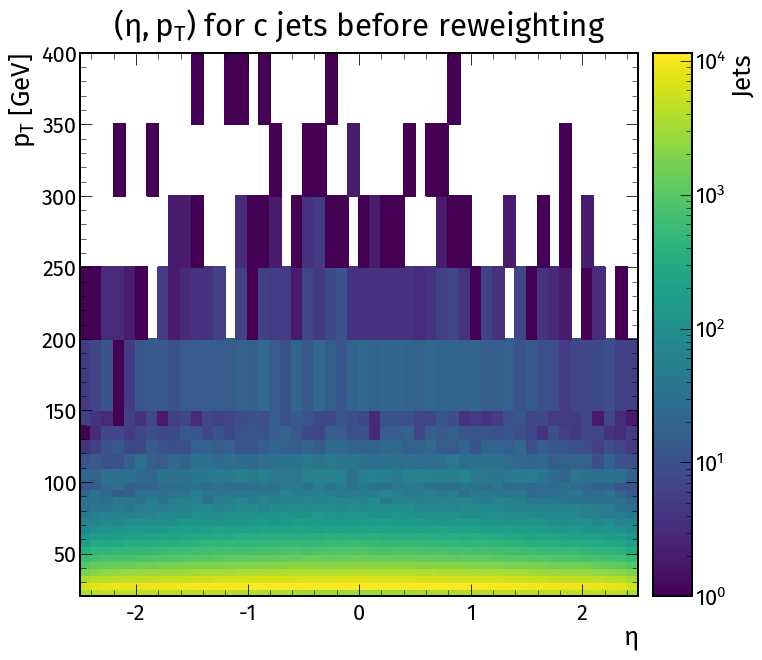

In [390]:
filename = 'c_histo_alt_clip'
ax = hep.hist2dplot(c_histo_alt[:,:27], eta_edges_alt, pt_edges_alt[:27], norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for c jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

/home/um106329/miniconda3/envs/my-env/lib/python3.8/site-packages/mplhep/plot.py:527: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(X, Y, H, **kwargs)


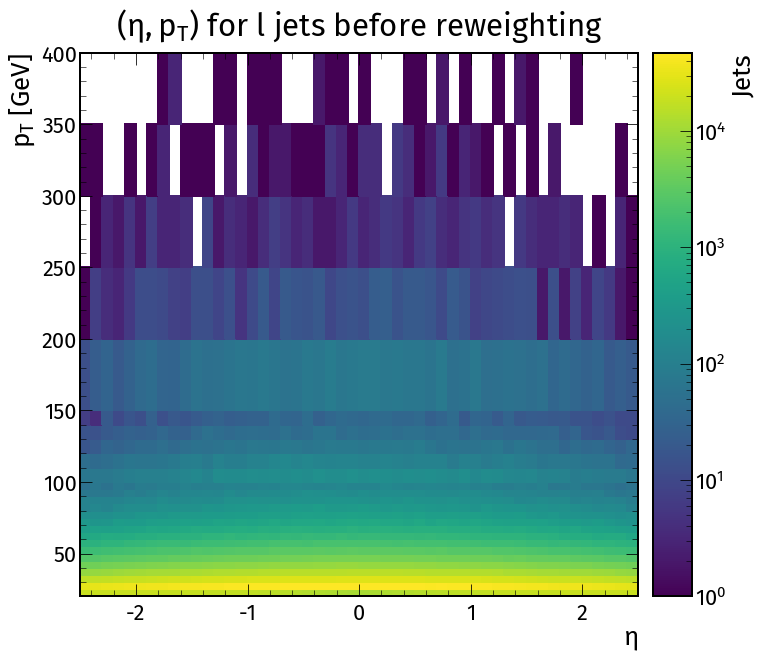

In [391]:
filename = 'l_histo_alt_clip'
ax = hep.hist2dplot(l_histo_alt[:,:27], eta_edges_alt, pt_edges_alt[:27], norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for l jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

In [392]:
b_histo_alt_normed = b_histo_alt/sum(b_histo_alt.flatten())
c_histo_alt_normed = c_histo_alt/sum(c_histo_alt.flatten())
l_histo_alt_normed = l_histo_alt/sum(l_histo_alt.flatten())

/home/um106329/miniconda3/envs/my-env/lib/python3.8/site-packages/mplhep/plot.py:527: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(X, Y, H, **kwargs)


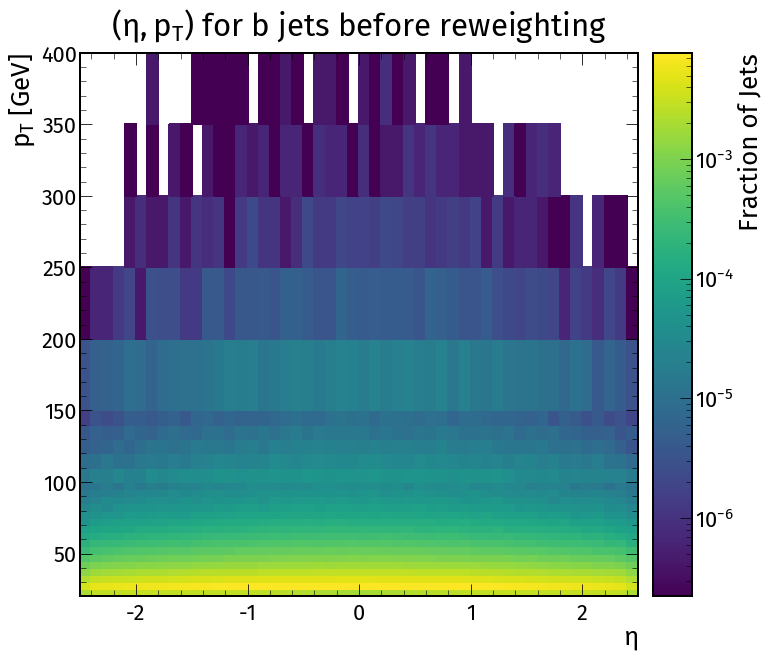

In [393]:
filename = 'b_histo_alt_normed_clip'
ax = hep.hist2dplot(b_histo_alt_normed[:,:27], eta_edges_alt, pt_edges_alt[:27], norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for b jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Fraction of Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

/home/um106329/miniconda3/envs/my-env/lib/python3.8/site-packages/mplhep/plot.py:527: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(X, Y, H, **kwargs)


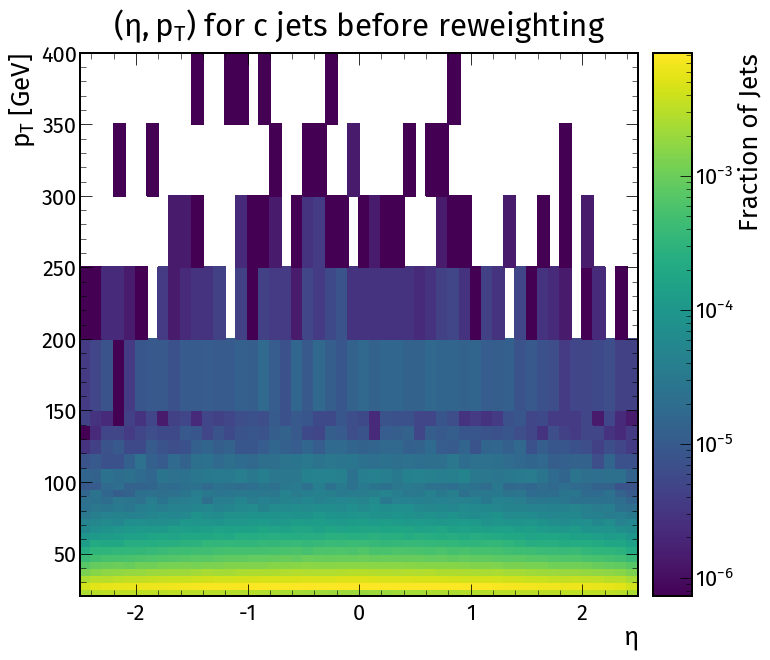

In [394]:
filename = 'c_histo_alt_normed_clip'
ax = hep.hist2dplot(c_histo_alt_normed[:,:27], eta_edges_alt, pt_edges_alt[:27], norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for c jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Fraction of Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

/home/um106329/miniconda3/envs/my-env/lib/python3.8/site-packages/mplhep/plot.py:527: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(X, Y, H, **kwargs)


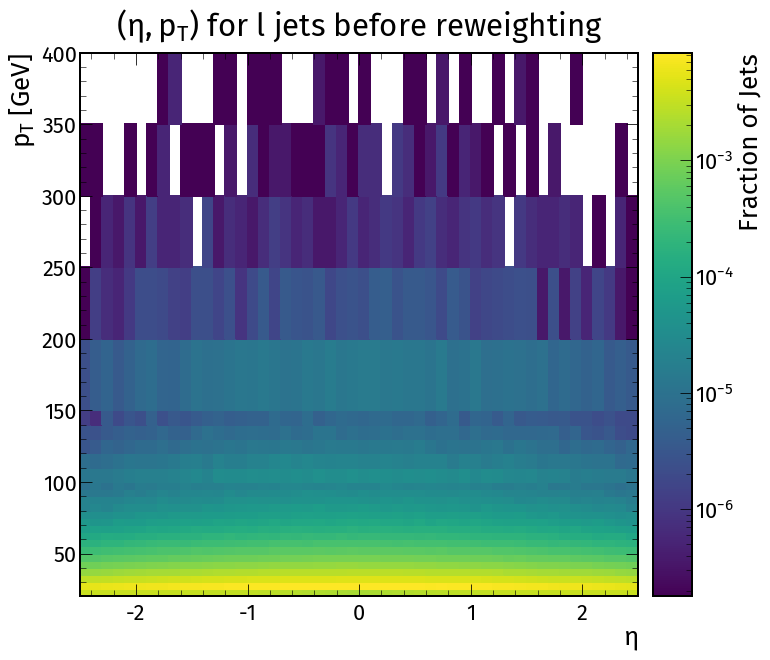

In [395]:
filename = 'l_histo_alt_normed_clip'
ax = hep.hist2dplot(l_histo_alt_normed[:,:27], eta_edges_alt, pt_edges_alt[:27], norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' for l jets before reweighting',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Fraction of Jets')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

In [396]:
average_normed_histo_alt = (b_histo_alt_normed + c_histo_alt_normed + l_histo_alt_normed)/3

In [397]:
b_weights_pt_eta_average_alt = average_normed_histo_alt/b_histo_alt_normed
c_weights_pt_eta_average_alt = average_normed_histo_alt/c_histo_alt_normed
l_weights_pt_eta_average_alt = average_normed_histo_alt/l_histo_alt_normed

<ipython-input-397-5e00afd02528>:1: RuntimeWarning: divide by zero encountered in true_divide
  b_weights_pt_eta_average_alt = average_normed_histo_alt/b_histo_alt_normed
<ipython-input-397-5e00afd02528>:1: RuntimeWarning: invalid value encountered in true_divide
  b_weights_pt_eta_average_alt = average_normed_histo_alt/b_histo_alt_normed
<ipython-input-397-5e00afd02528>:2: RuntimeWarning: divide by zero encountered in true_divide
  c_weights_pt_eta_average_alt = average_normed_histo_alt/c_histo_alt_normed
<ipython-input-397-5e00afd02528>:2: RuntimeWarning: invalid value encountered in true_divide
  c_weights_pt_eta_average_alt = average_normed_histo_alt/c_histo_alt_normed
<ipython-input-397-5e00afd02528>:3: RuntimeWarning: divide by zero encountered in true_divide
  l_weights_pt_eta_average_alt = average_normed_histo_alt/l_histo_alt_normed
<ipython-input-397-5e00afd02528>:3: RuntimeWarning: invalid value encountered in true_divide
  l_weights_pt_eta_average_alt = average_normed_histo_

In [398]:
b_weights_pt_eta_flav_alt = b_weights_pt_eta_average_alt * factor_b
c_weights_pt_eta_flav_alt = c_weights_pt_eta_average_alt * factor_c
l_weights_pt_eta_flav_alt = l_weights_pt_eta_average_alt * factor_l

In [399]:
b_weights_pt_eta_flav_balanced_alt = b_weights_pt_eta_flav_alt / 3
c_weights_pt_eta_flav_balanced_alt = c_weights_pt_eta_flav_alt / 3
l_weights_pt_eta_flav_balanced_alt = l_weights_pt_eta_flav_alt / 3

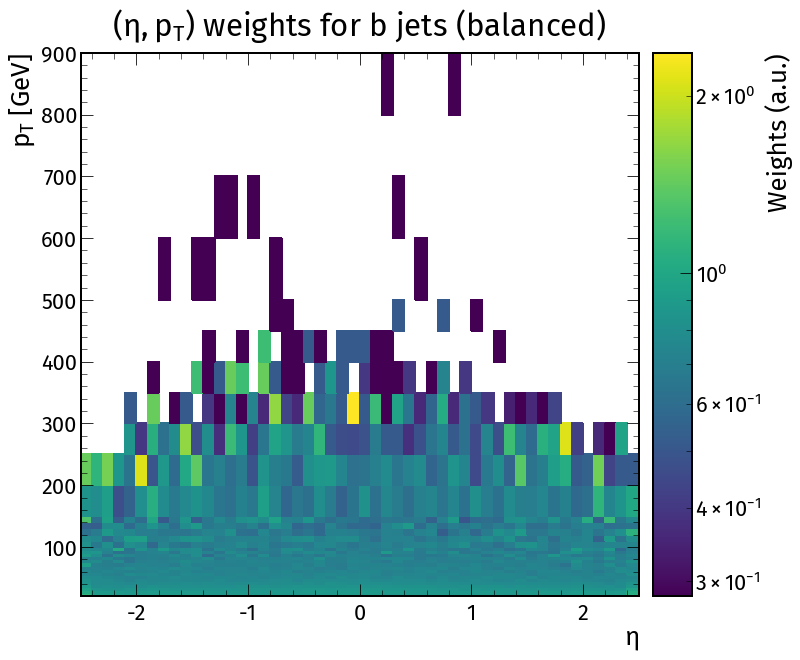

In [400]:
filename = 'b_weights_pt_eta_flav_balanced_alt'
ax = hep.hist2dplot(b_weights_pt_eta_flav_balanced_alt, eta_edges_alt, pt_edges_alt, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for b jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

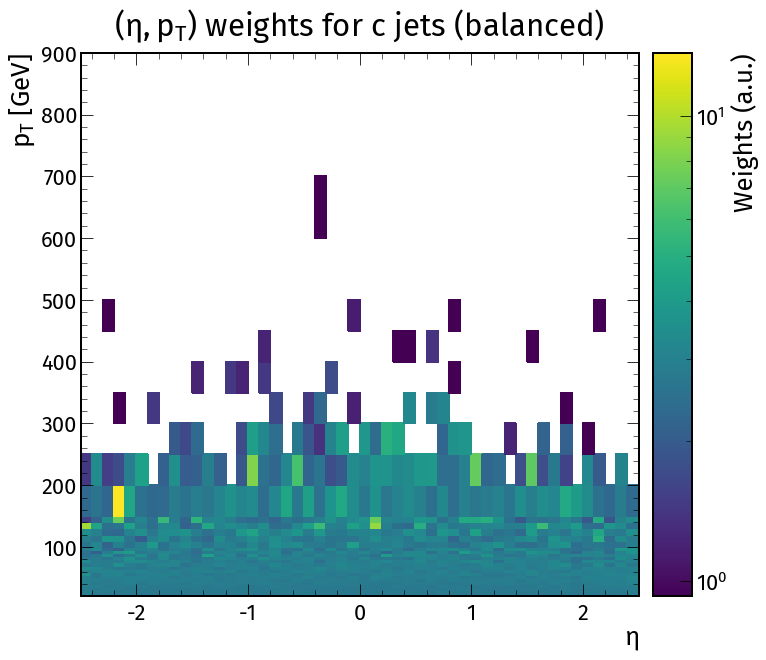

In [401]:
filename = 'c_weights_pt_eta_flav_balanced_alt'
ax = hep.hist2dplot(c_weights_pt_eta_flav_balanced_alt, eta_edges_alt, pt_edges_alt, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for c jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

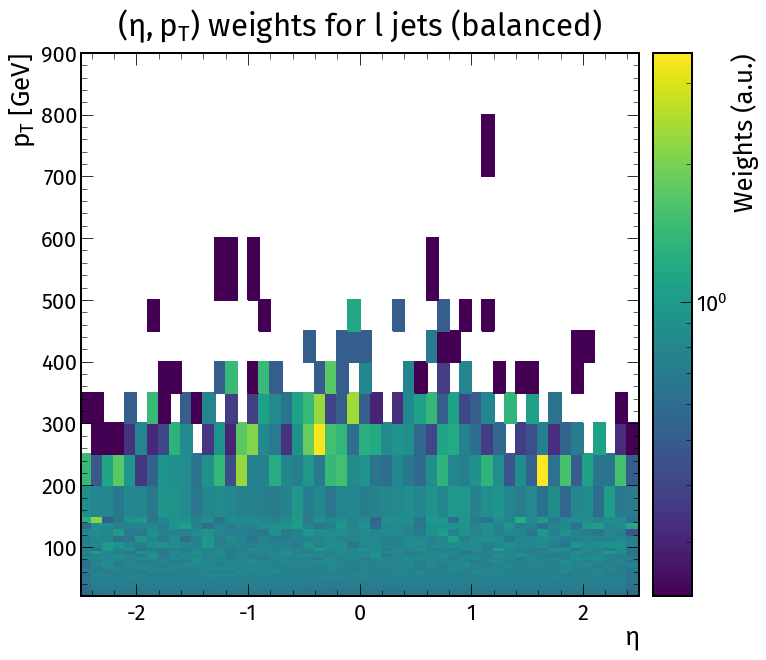

In [402]:
filename = 'l_weights_pt_eta_flav_balanced_alt'
ax = hep.hist2dplot(l_weights_pt_eta_flav_balanced_alt, eta_edges_alt, pt_edges_alt, norm=LogNorm(),edgecolors='face')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$p_T$ [GeV]')
plt.title(r'$(\eta, p_T)$'+' weights for l jets (balanced)',y=1.02)
#plt.savefig('preparations/both_b_histo.png',dpi=400,transparent=False,facecolor='white')
#plt.savefig('preparations/both_b_histo_v2.pdf', bbox_inches='tight')
plt.gca().collections[-1].colorbar.set_label('Weights (a.u.)')
plt.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.svg'.format(filename), bbox_inches='tight')
plt.savefig('plots/{}.png'.format(filename), bbox_inches='tight')

In [429]:
b_reweighted_pt_eta_flav_balanced_alt = b_weights_pt_eta_flav_balanced_alt * b_histo_alt
c_reweighted_pt_eta_flav_balanced_alt = c_weights_pt_eta_flav_balanced_alt * c_histo_alt
l_reweighted_pt_eta_flav_balanced_alt = l_weights_pt_eta_flav_balanced_alt * l_histo_alt

<ipython-input-429-93528abd3ad1>:1: RuntimeWarning: invalid value encountered in multiply
  b_reweighted_pt_eta_flav_balanced_alt = b_weights_pt_eta_flav_balanced_alt * b_histo_alt
<ipython-input-429-93528abd3ad1>:2: RuntimeWarning: invalid value encountered in multiply
  c_reweighted_pt_eta_flav_balanced_alt = c_weights_pt_eta_flav_balanced_alt * c_histo_alt
<ipython-input-429-93528abd3ad1>:3: RuntimeWarning: invalid value encountered in multiply
  l_reweighted_pt_eta_flav_balanced_alt = l_weights_pt_eta_flav_balanced_alt * l_histo_alt


### Save relevant weights

In [403]:
np.save(weights_path+'b_weights_pt_eta_flav_balanced_alt.npy', b_weights_pt_eta_flav_balanced_alt)
np.save(weights_path+'c_weights_pt_eta_flav_balanced_alt.npy', c_weights_pt_eta_flav_balanced_alt)
np.save(weights_path+'l_weights_pt_eta_flav_balanced_alt.npy', l_weights_pt_eta_flav_balanced_alt)

Besides the regions with large |jet_eta|, there are not too many differences between the different flavors (apart from the class imbalance) - maybe the dataset used a mixture of processes that average out any specifics based on flavor...

<hr>

## Investigate 1D histograms

In [404]:
pt_marginalb_dist_before = np.nan_to_num(b_histo).sum(axis=0)
eta_marginalb_dist_before = np.nan_to_num(b_histo).sum(axis=1)

In [405]:
pt_marginalc_dist_before = np.nan_to_num(c_histo).sum(axis=0)
eta_marginalc_dist_before = np.nan_to_num(c_histo).sum(axis=1)

In [406]:
pt_marginall_dist_before = np.nan_to_num(l_histo).sum(axis=0)
eta_marginall_dist_before = np.nan_to_num(l_histo).sum(axis=1)

In [407]:
pt_marginalb_dist_alt_before = np.nan_to_num(b_histo_alt).sum(axis=0)
eta_marginalb_dist_alt_before = np.nan_to_num(b_histo_alt).sum(axis=1)

In [408]:
pt_marginalc_dist_alt_before = np.nan_to_num(c_histo_alt).sum(axis=0)
eta_marginalc_dist_alt_before = np.nan_to_num(c_histo_alt).sum(axis=1)

In [409]:
pt_marginall_dist_alt_before = np.nan_to_num(l_histo_alt).sum(axis=0)
eta_marginall_dist_alt_before = np.nan_to_num(l_histo_alt).sum(axis=1)

Reweighted

In [426]:
pt_marginalb_dist_after = np.nan_to_num(b_reweighted_pt_eta_flav_balanced).sum(axis=0)
eta_marginalb_dist_after = np.nan_to_num(b_reweighted_pt_eta_flav_balanced).sum(axis=1)

In [427]:
pt_marginalc_dist_after = np.nan_to_num(c_reweighted_pt_eta_flav_balanced).sum(axis=0)
eta_marginalc_dist_after = np.nan_to_num(c_reweighted_pt_eta_flav_balanced).sum(axis=1)

In [428]:
pt_marginall_dist_after = np.nan_to_num(l_reweighted_pt_eta_flav_balanced).sum(axis=0)
eta_marginall_dist_after = np.nan_to_num(l_reweighted_pt_eta_flav_balanced).sum(axis=1)

In [430]:
pt_marginalb_dist_alt_after = np.nan_to_num(b_reweighted_pt_eta_flav_balanced_alt).sum(axis=0)
eta_marginalb_dist_alt_after = np.nan_to_num(b_reweighted_pt_eta_flav_balanced_alt).sum(axis=1)

In [431]:
pt_marginalc_dist_alt_after = np.nan_to_num(c_reweighted_pt_eta_flav_balanced_alt).sum(axis=0)
eta_marginalc_dist_alt_after = np.nan_to_num(c_reweighted_pt_eta_flav_balanced_alt).sum(axis=1)

In [432]:
pt_marginall_dist_alt_after = np.nan_to_num(l_reweighted_pt_eta_flav_balanced_alt).sum(axis=0)
eta_marginall_dist_alt_after = np.nan_to_num(l_reweighted_pt_eta_flav_balanced_alt).sum(axis=1)

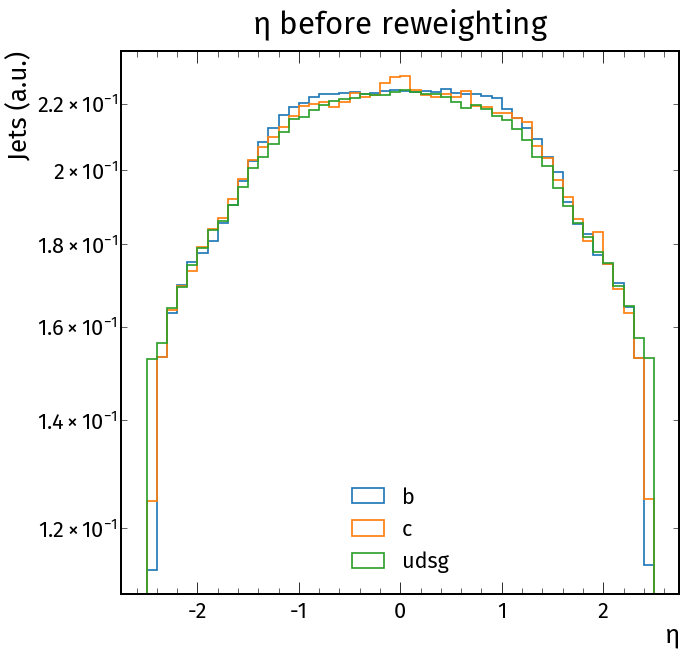

In [420]:
plt.hist(eta_edges[:-1],bins=50,range=(-2.5,2.5),weights=eta_marginalb_dist_before,density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(eta_edges[:-1],bins=50,range=(-2.5,2.5),weights=eta_marginalc_dist_before,density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(eta_edges[:-1],bins=50,range=(-2.5,2.5),weights=eta_marginall_dist_before,density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='lower center')
plt.xlabel(r'$\eta$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$\eta$ before reweighting',y=1.02)
plt.savefig('plots/eta_before_log.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/eta_before_log.pdf', bbox_inches='tight')
plt.savefig('plots/eta_before_log.svg', bbox_inches='tight')

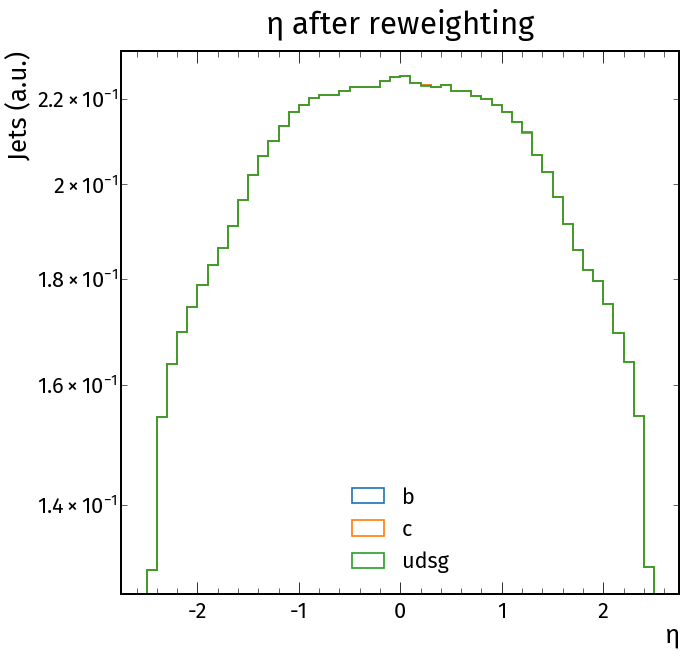

In [433]:
plt.hist(eta_edges[:-1],bins=50,range=(-2.5,2.5),weights=eta_marginalb_dist_after,density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(eta_edges[:-1],bins=50,range=(-2.5,2.5),weights=eta_marginalc_dist_after,density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(eta_edges[:-1],bins=50,range=(-2.5,2.5),weights=eta_marginall_dist_after,density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='lower center')
plt.xlabel(r'$\eta$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$\eta$ after reweighting',y=1.02)
plt.savefig('plots/eta_after_log.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/eta_after_log.pdf', bbox_inches='tight')
plt.savefig('plots/eta_after_log.svg', bbox_inches='tight')

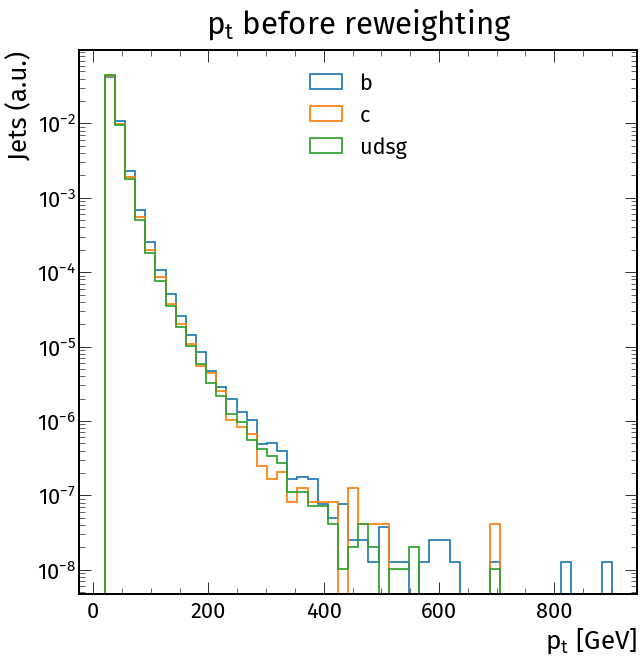

In [422]:
plt.hist(pt_edges[:-1],bins=50,range=(20,900),weights=pt_marginalb_dist_before,density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(pt_edges[:-1],bins=50,range=(20,900),weights=pt_marginalc_dist_before,density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(pt_edges[:-1],bins=50,range=(20,900),weights=pt_marginall_dist_before,density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='upper center')
plt.xlabel(r'$p_t\ [GeV]$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$p_t$ before reweighting',y=1.02)
plt.savefig('plots/pt_before_log.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/pt_before_log.pdf', bbox_inches='tight')
plt.savefig('plots/pt_before_log.svg', bbox_inches='tight')

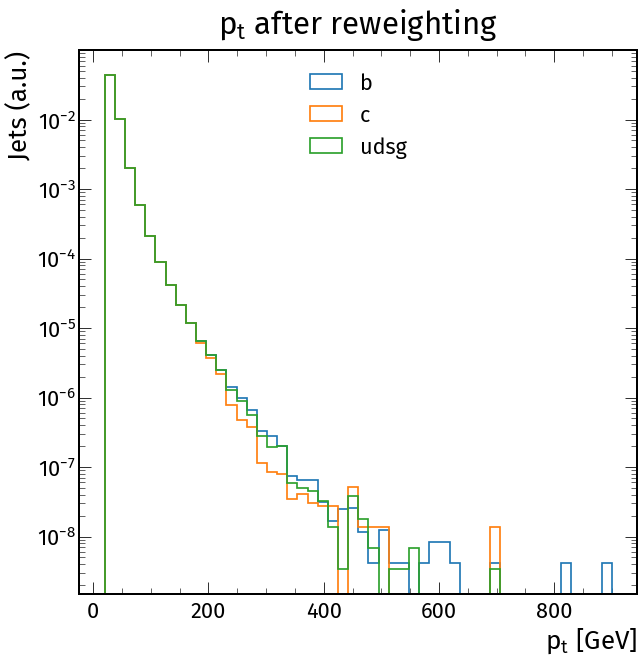

In [434]:
plt.hist(pt_edges[:-1],bins=50,range=(20,900),weights=pt_marginalb_dist_after,density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(pt_edges[:-1],bins=50,range=(20,900),weights=pt_marginalc_dist_after,density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(pt_edges[:-1],bins=50,range=(20,900),weights=pt_marginall_dist_after,density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='upper center')
plt.xlabel(r'$p_t\ [GeV]$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$p_t$ after reweighting',y=1.02)
plt.savefig('plots/pt_after_log.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/pt_after_log.pdf', bbox_inches='tight')
plt.savefig('plots/pt_after_log.svg', bbox_inches='tight')

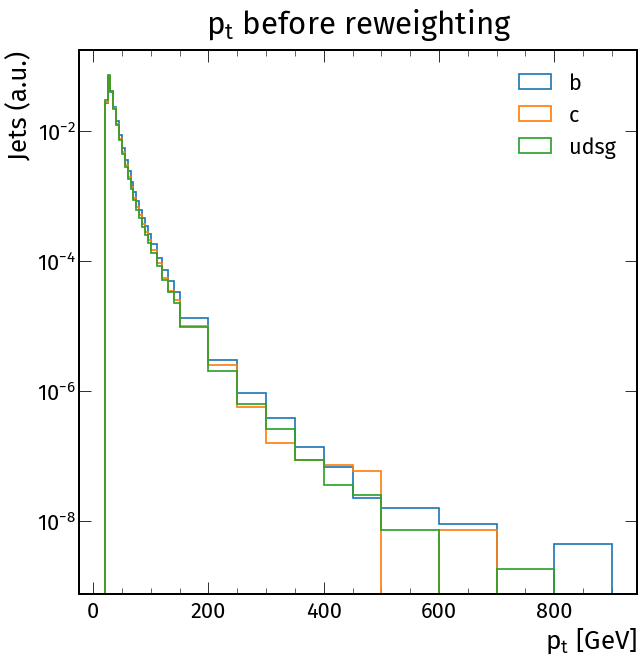

In [423]:
plt.hist(pt_edges_alt[:-1],pt_edges_alt,weights=pt_marginalb_dist_alt_before,density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(pt_edges_alt[:-1],pt_edges_alt,weights=pt_marginalc_dist_alt_before,density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(pt_edges_alt[:-1],pt_edges_alt,weights=pt_marginall_dist_alt_before,density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='upper right')
plt.xlabel(r'$p_t\ [GeV]$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$p_t$ before reweighting',y=1.02)
plt.savefig('plots/pt_before_alt_log.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/pt_before_alt_log.pdf', bbox_inches='tight')
plt.savefig('plots/pt_before_alt_log.svg', bbox_inches='tight')

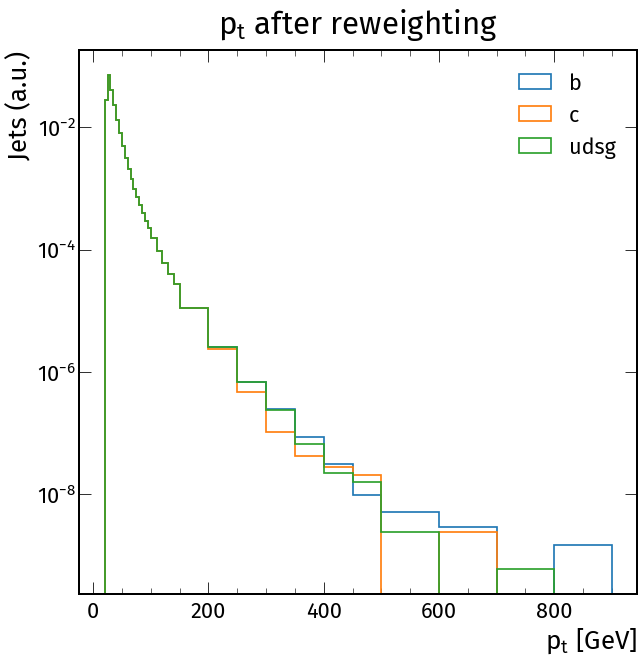

In [435]:
plt.hist(pt_edges_alt[:-1],pt_edges_alt,weights=pt_marginalb_dist_alt_after,density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(pt_edges_alt[:-1],pt_edges_alt,weights=pt_marginalc_dist_alt_after,density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(pt_edges_alt[:-1],pt_edges_alt,weights=pt_marginall_dist_alt_after,density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='upper right')
plt.xlabel(r'$p_t\ [GeV]$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$p_t$ after reweighting',y=1.02)
plt.savefig('plots/pt_after_alt_log.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/pt_after_alt_log.pdf', bbox_inches='tight')
plt.savefig('plots/pt_after_alt_log.svg', bbox_inches='tight')

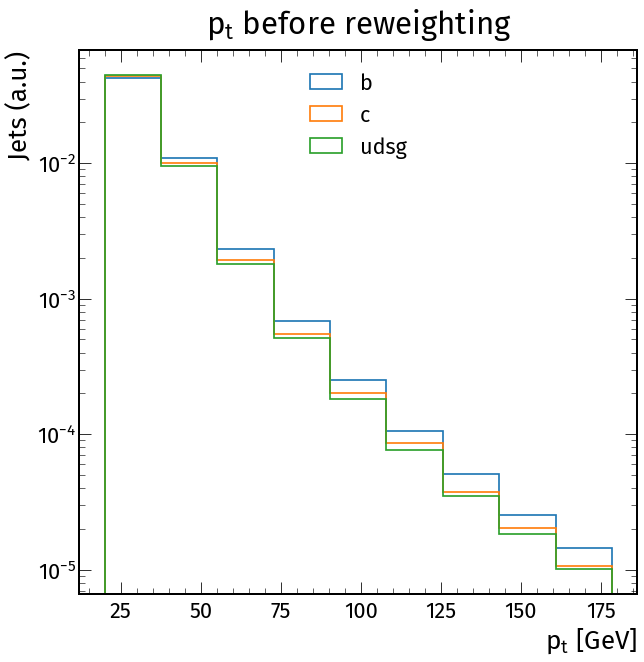

In [424]:
plt.hist(pt_edges[:9],pt_edges[0:10],weights=pt_marginalb_dist_before[:9],density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(pt_edges[:9],pt_edges[0:10],weights=pt_marginalc_dist_before[:9],density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(pt_edges[:9],pt_edges[0:10],weights=pt_marginall_dist_before[:9],density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='upper center')
plt.xlabel(r'$p_t\ [GeV]$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$p_t$ before reweighting',y=1.02)
plt.savefig('plots/pt_before_log_20to178.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/pt_before_log_20to178.pdf', bbox_inches='tight')
plt.savefig('plots/pt_before_log_20to178.svg', bbox_inches='tight')

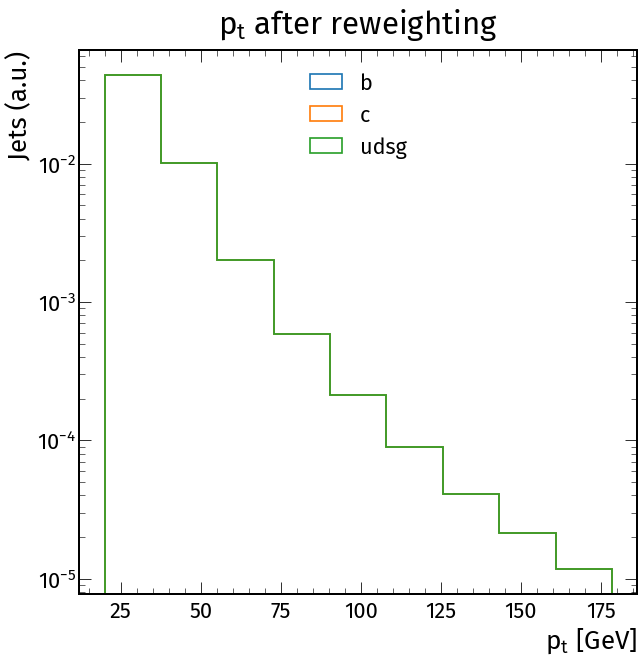

In [436]:
plt.hist(pt_edges[:9],pt_edges[0:10],weights=pt_marginalb_dist_after[:9],density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(pt_edges[:9],pt_edges[0:10],weights=pt_marginalc_dist_after[:9],density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(pt_edges[:9],pt_edges[0:10],weights=pt_marginall_dist_after[:9],density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='upper center')
plt.xlabel(r'$p_t\ [GeV]$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$p_t$ after reweighting',y=1.02)
plt.savefig('plots/pt_after_log_20to178.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/pt_after_log_20to178.pdf', bbox_inches='tight')
plt.savefig('plots/pt_after_log_20to178.svg', bbox_inches='tight')

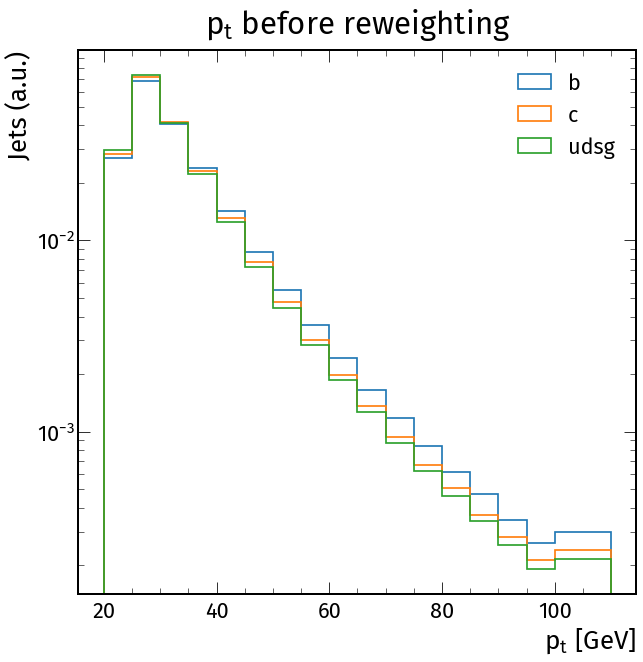

In [425]:
plt.hist(pt_edges_alt[:19],pt_edges_alt[0:18],weights=pt_marginalb_dist_alt_before[:19],density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(pt_edges_alt[:19],pt_edges_alt[0:18],weights=pt_marginalc_dist_alt_before[:19],density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(pt_edges_alt[:19],pt_edges_alt[0:18],weights=pt_marginall_dist_alt_before[:19],density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='upper right')
plt.xlabel(r'$p_t\ [GeV]$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$p_t$ before reweighting',y=1.02)
plt.savefig('plots/pt_before_alt_log_20to110.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/pt_before_alt_log_20to110.pdf', bbox_inches='tight')
plt.savefig('plots/pt_before_alt_log_20to110.svg', bbox_inches='tight')

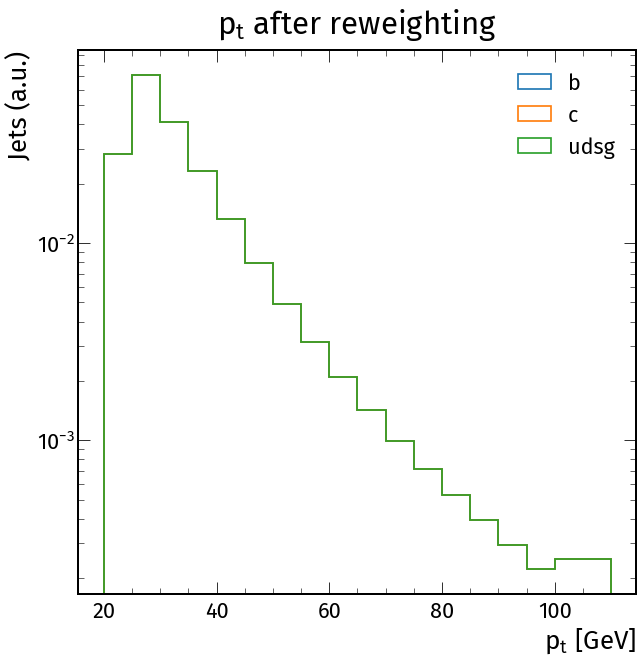

In [437]:
plt.hist(pt_edges_alt[:19],pt_edges_alt[0:18],weights=pt_marginalb_dist_alt_after[:19],density=True,histtype='step',linewidth=1.7,log=True,label='b')
plt.hist(pt_edges_alt[:19],pt_edges_alt[0:18],weights=pt_marginalc_dist_alt_after[:19],density=True,histtype='step',linewidth=1.7,log=True,label='c')
plt.hist(pt_edges_alt[:19],pt_edges_alt[0:18],weights=pt_marginall_dist_alt_after[:19],density=True,histtype='step',linewidth=1.7,log=True,label='udsg')
plt.legend(loc='upper right')
plt.xlabel(r'$p_t\ [GeV]$')
plt.ylabel(r'Jets (a.u.)')
plt.title(r'$p_t$ after reweighting',y=1.02)
plt.savefig('plots/pt_after_alt_log_20to110.png', bbox_inches='tight', dpi=600, transparent=False, facecolor='white')
plt.savefig('plots/pt_after_alt_log_20to110.pdf', bbox_inches='tight')
plt.savefig('plots/pt_after_alt_log_20to110.svg', bbox_inches='tight')